<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/alldata/Replicate_GCP1_main_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data/all_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data/all_data


In [ ]:
!pip uninstall -y gcpdatautils
!pip install git+https://github.com/AvantiShri/gcpdatautils.git

Found existing installation: gcpdatautils 0.1.0.0
Uninstalling gcpdatautils-0.1.0.0:
  Successfully uninstalled gcpdatautils-0.1.0.0
  Cloning https://github.com/AvantiShri/gcpdatautils.git to /tmp/pip-req-build-n9z7z7sm
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-n9z7z7sm
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 175ed72924dbe57a7ec920341a2dcc015a584fb1
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.0.0-py3-none-any.whl size=5880 sha256=196646ea2cdc6b557026f5fd8b683be4e59f48199192da197b7d0ea2f70f7db8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8fy6g898/wheels/fe/f9/b7/d5afa50c9e111dcf3a66edb57f0c2273e54d108591664596b8
Successfully built gcpdatautils


In [ ]:
from gcpdatautils import parse_events_html

#download the formal event registry and read the events in
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html", exclude_events_longer_than_days=7)

--2023-12-19 15:49:37--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [  <=>               ] 184.64K   389KB/s    in 0.5s    

2023-12-19 15:49:38 (389 KB/s) - ‘pred_formal.html’ saved [189067]

Skipping because event is more than 7 days long! 25 Pray for Peace 1999-04-03 20:00:00 1999-05-03 19:01:59
Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because event is more than 7 days long! 51 Kursk, 10 days 2000-08-12 07:28:00 2000-08-21 14:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because event is more than 7 days long! 79 Buddhist Stup

In [ ]:
len(included_events)

492

In [ ]:
from gcpdatautils import GCPHdf5DataReader
gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


In [18]:
from gcpdatautils import GCPMissingDataError
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy


def compare_different_calc_approaches(egg_values, blocksizes):
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row

  egg_zscores = (egg_values - 100)/np.sqrt(50)

  pvaltozs_sumthensquare = []
  pvaltozs_squarethensum = []
  for blocksize in blocksizes:
    num_blocks = int((len(egg_zscores) - (len(egg_zscores)%blocksize))/blocksize)
    num_eggs = egg_zscores.shape[-1]
    blockreshaped_eggzscores = egg_zscores[0 : blocksize*num_blocks].reshape(num_blocks, blocksize, num_eggs)

    perblock_peregg_zsums = np.sum(blockreshaped_eggzscores, axis=1)/np.sqrt(blocksize) #shape becomes (num_blocks x num_eggs), nan if any value in the block is nan
    num_nonnan_eggblocks = np.sum(np.isnan(perblock_peregg_zsums)==False, axis=-1) #shape is num_blocks

    #compute p value if we sum across eggs first, then square
    perblock_zsums = np.nansum(perblock_peregg_zsums, axis=1)/np.maximum(np.sqrt(num_nonnan_eggblocks), 1) #shape becomes num_blocks
    pvaltoz_sumthensquare = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(x=np.nansum(np.square(perblock_zsums)), df=np.sum(num_nonnan_eggblocks > 0)))
    pvaltozs_sumthensquare.append(pvaltoz_sumthensquare)

    #compute p value if we square first, then sum across eggs and timesteps
    pvaltoz_squarethensum = scipy.stats.norm.ppf(scipy.stats.chi2.cdf(np.nansum(np.square(perblock_peregg_zsums)),
                                                  df=np.sum(num_nonnan_eggblocks)))
    #the above code sometimes returns cdfs of 1.0, so we will also use the normal approx and take the less significant of the two
    pvaltoz_squarethensum = min(pvaltoz_squarethensum,
                                np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )
    pvaltozs_squarethensum.append(pvaltoz_squarethensum)

  return pvaltozs_sumthensquare, pvaltozs_squarethensum


BLOCKSIZES = [1, 2, 3, 6, 8, 10, 15]
all_pvaltozs_sumthensquare = []
all_pvaltozs_squarethensum = []

control_timeshifts = [-3, -2, -1, 1, 2, 3]

controls_all_pvaltozs_sumthensquare = dict([(x,[]) for x in control_timeshifts])
controls_all_pvaltozs_squarethensum = dict([(x,[]) for x in control_timeshifts])

surviving_events = [] #in case we encounter missing data errors
#read the data for the events

eventcount = 0

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime)[0]
    event_pvaltozs_sumthensquare, event_pvaltozs_squarethensum = compare_different_calc_approaches(event_data, BLOCKSIZES)
    print("Event data: Sum then square:", pvaltozs_sumthensquare)
    print("Event data: Square then sum:", pvaltozs_squarethensum)


    print("For controls...")
    thisevent_control_pvaltozs_sumthensquare = {}
    thisevent_control_pvaltozs_squarethensum = {}
    for control_timeshift in control_timeshifts:
      timeshift = timedelta(seconds=control_timeshift*duration)
      control_starttime = start_datetime + timeshift
      control_endtime = end_datetime + timeshift
      print("Control start and end:", control_starttime, control_endtime)
      control_data = gcp_data_reader.fetch_data(control_starttime, control_endtime)[0]
      pvaltozs_sumthensquare, pvaltozs_squarethensum = compare_different_calc_approaches(control_data, BLOCKSIZES)
      print("Control data: Sum then square:", pvaltozs_sumthensquare)
      print("Control data: Square then sum:", pvaltozs_squarethensum)
      thisevent_control_pvaltozs_sumthensquare[control_timeshift] = pvaltozs_sumthensquare
      thisevent_control_pvaltozs_squarethensum[control_timeshift] = pvaltozs_squarethensum

    all_pvaltozs_sumthensquare.append(event_pvaltozs_sumthensquare)
    all_pvaltozs_squarethensum.append(event_pvaltozs_squarethensum)
    for control_timeshift in control_timeshifts:
      controls_all_pvaltozs_sumthensquare[control_timeshift].append(
          thisevent_control_pvaltozs_sumthensquare[control_timeshift])
      controls_all_pvaltozs_squarethensum[control_timeshift].append(
          thisevent_control_pvaltozs_squarethensum[control_timeshift])
    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)


EVENT COUNT 1
1 Embassy 1998-08-07 07:15:00 1998-08-07 10:14:59 10800.0
Event data: Sum then square: [0.7067067218339302, 0.028507108994642493, 0.14838747419467105, -0.6644150872369667, -0.9415691609297354, -0.08274700526303422, 0.578987905860929]
Event data: Square then sum: [0.9019275575035604, 1.364148730536776, 1.4622406157896919, 1.2737035292348848, 0.7800405975448516, 0.25255973392290904, 0.7424325492973984]
For controls...
Control start and end: 1998-08-06 22:15:00 1998-08-07 01:14:59
Control data: Sum then square: [0.20401064650084322, -0.5407575183690697, 0.051668614285845064, -0.6933143323235241, -0.5410991539453609, 0.28226483905368654, -0.17146242233240352]
Control data: Square then sum: [0.986325591126435, 0.062019144666179755, 0.13676848076113812, -0.29323727609680816, -0.5550241537108378, 0.8858060486219064, 0.7233136774172021]
Control start and end: 1998-08-07 01:15:00 1998-08-07 04:14:59
Control data: Sum then square: [0.22866215602816067, 0.004650932540809376, -0.7381

<ipython-input-18-1a10e8aa1026>:40: RuntimeWarning: invalid value encountered in double_scalars
  np.nansum(np.square(perblock_peregg_zsums)-1)/np.sqrt(2*np.sum(num_nonnan_eggblocks)) )


Streaming output truncated to the last 5000 lines.
Control data: Sum then square: [0.822558713783438, 0.7882494406852751, -0.48658735748378207, -0.857179474901155, 0.6346436466372763, 1.8888258895373125, 0.7308556518670069]
Control data: Square then sum: [-1.3256724845149266, -0.4632143612516531, 0.8376197582038701, 0.8154589341225145, -0.02482834772956066, 0.8979831489155887, 1.0691337509889312]
Control start and end: 2009-12-26 08:00:00 2009-12-26 15:59:59
Control data: Sum then square: [-0.04412264069956653, 0.7969556929512727, 0.050171888284673616, -1.107298890150811, 0.6677138127164853, 0.517255444899706, -0.3198413591284807]
Control data: Square then sum: [0.2562532571523227, -0.394724244455798, -0.11542780153091506, -0.26618357739611076, -1.3900229659452448, -1.3175710060042518, -0.1018419183966865]
Control start and end: 2009-12-26 16:00:00 2009-12-26 23:59:59
Control data: Sum then square: [-0.7476223843058675, 0.01793696328459861, -1.5022453838883454, -2.2273844208025166, -2.

num events after dropping events with missing data: 492



Blocksize: 1 seconds
************TEST TYPE: actual
Meta-analysis Z-score if squaring *after* summing: 6.620536580807985 pval: 1.789490777781566e-11
Meta-analysis Z-score if squaring *before* summing 6.50686042176585 pval:  3.836886364183556e-11
Argmax event for square after summing: ('487', 'September 21', datetime.datetime(2014, 9, 21, 0, 0), datetime.datetime(2014, 9, 21, 23, 59, 59), 86400.0) 3.220190532336857
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', datetime.datetime(2008, 8, 29, 2, 0), datetime.datetime(2008, 8, 29, 3, 59, 59), 7200.0) 3.693110187603022
Correlation between the two scores: PearsonRResult(statistic=0.08121972654966175, pvalue=0.07333879024886934)


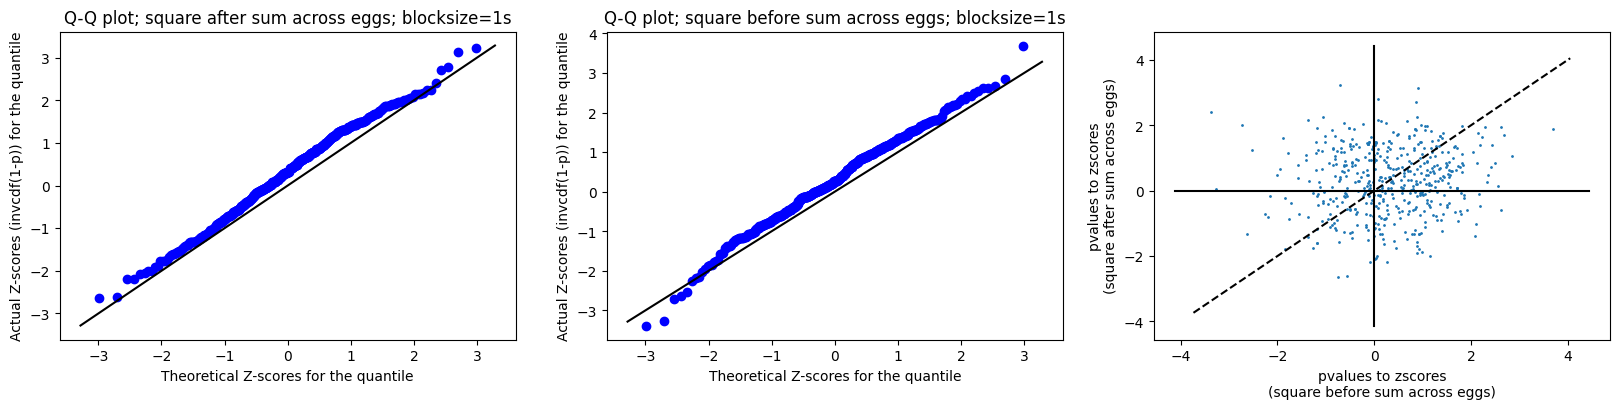

************TEST TYPE: controltimeshift_-3
Meta-analysis Z-score if squaring *after* summing: 0.8523814829875527 pval: 0.1970011970652169
Meta-analysis Z-score if squaring *before* summing 4.64008931711553 pval:  1.7412931216931327e-06
Argmax event for square after summing: ('24', 'Dow Tops 10000', datetime.datetime(1999, 3, 29, 20, 0), datetime.datetime(1999, 3, 29, 21, 59, 59), 7200.0) 2.965062817772213
Argmax event for square before summing: ('46', 'Papal Visit, Israel', datetime.datetime(2000, 3, 21, 0, 0), datetime.datetime(2000, 3, 26, 23, 59, 59), 518400.0) 3.714138512764052
Correlation between the two scores: PearsonRResult(statistic=0.17971890335112958, pvalue=6.652659068053173e-05)


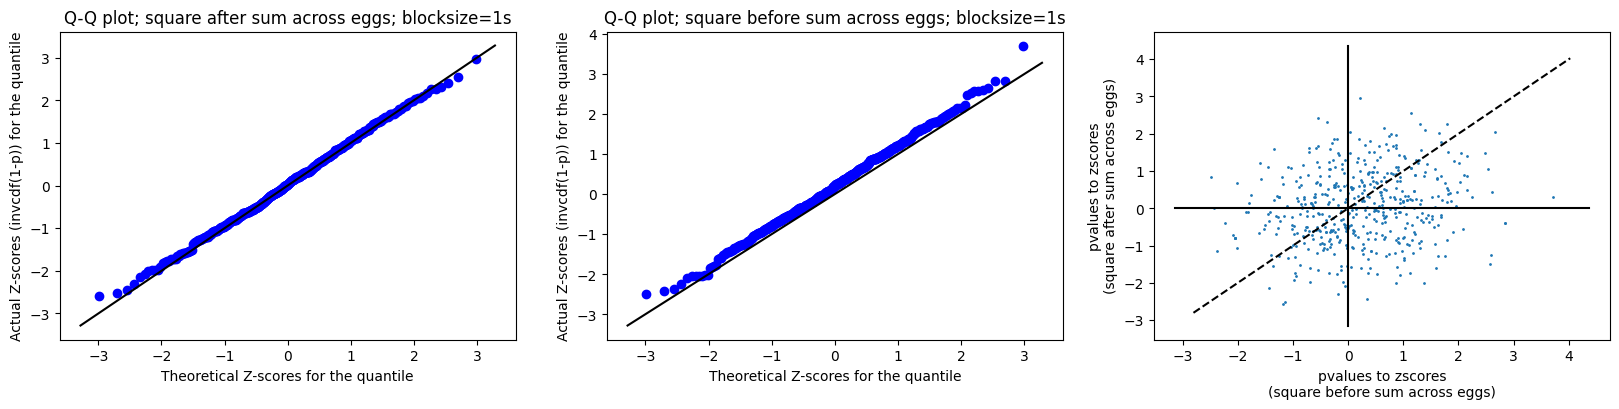

************TEST TYPE: controltimeshift_-2
Meta-analysis Z-score if squaring *after* summing: 1.1432195101524119 pval: 0.12647373189100364
Meta-analysis Z-score if squaring *before* summing 7.674688374782106 pval:  8.326672684688674e-15
Argmax event for square after summing: ('434', '12.12.12 Meditation', datetime.datetime(2012, 12, 12, 12, 30), datetime.datetime(2012, 12, 12, 15, 29, 59), 10800.0) 3.6758652241570964
Argmax event for square before summing: ('106', 'Tiger Woods Triumph', datetime.datetime(2002, 4, 14, 18, 22), datetime.datetime(2002, 4, 14, 22, 59, 59), 16680.0) 4.077320983912348
Correlation between the two scores: PearsonRResult(statistic=0.1123585743466031, pvalue=0.013100461662718488)


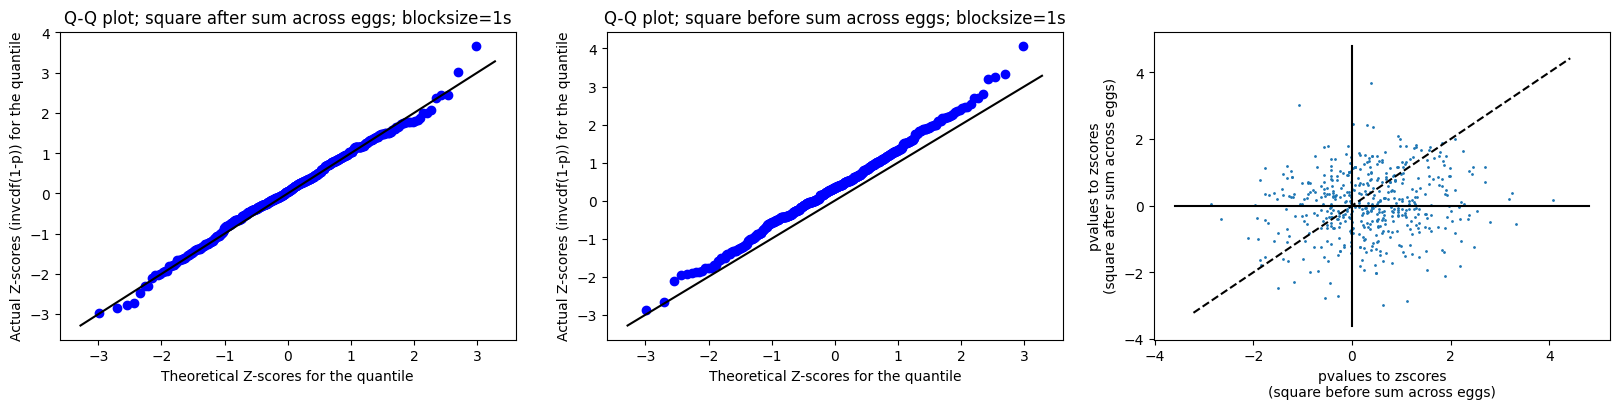

************TEST TYPE: controltimeshift_-1
Meta-analysis Z-score if squaring *after* summing: -0.1254396999412587 pval: 0.5499122698491843
Meta-analysis Z-score if squaring *before* summing 4.743704441768612 pval:  1.0492247712878822e-06
Argmax event for square after summing: ('282', 'Global Orgasm III', datetime.datetime(2008, 12, 21, 0, 0), datetime.datetime(2008, 12, 21, 23, 59, 59), 86400.0) 3.2726963032330283
Argmax event for square before summing: ('80', 'Terrorist Disaster, Sept 11', datetime.datetime(2001, 9, 11, 12, 35), datetime.datetime(2001, 9, 11, 16, 44, 59), 15000.0) 3.493571071271847
Correlation between the two scores: PearsonRResult(statistic=0.22388153449390905, pvalue=5.993218309137924e-07)


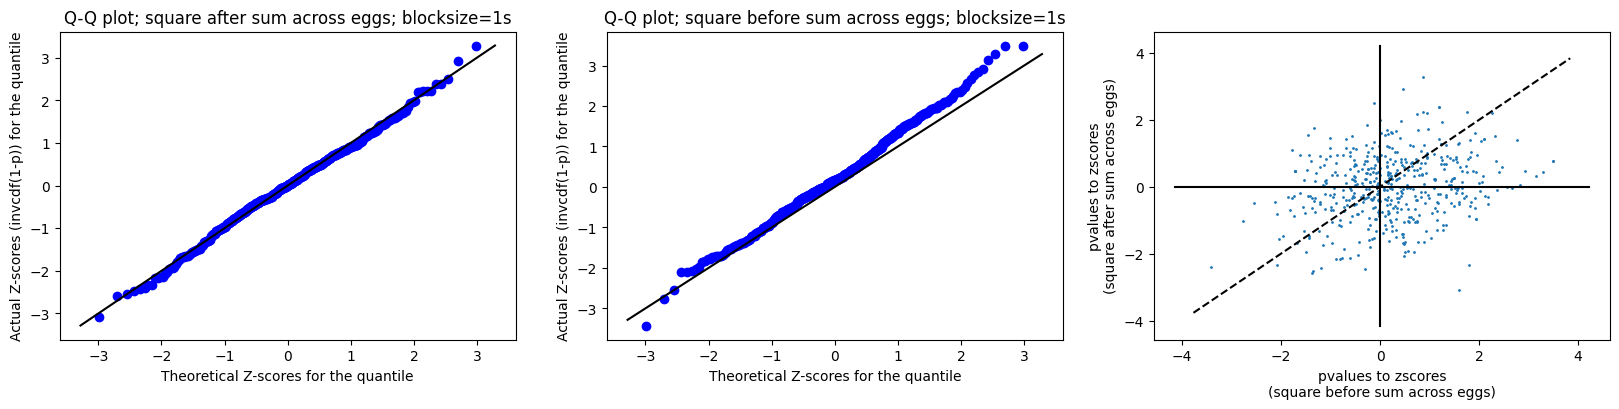

************TEST TYPE: controltimeshift_1
Meta-analysis Z-score if squaring *after* summing: -2.1871640245577053 pval: 0.9856347239442476
Meta-analysis Z-score if squaring *before* summing 2.699743739769941 pval:  0.0034696451982304533
Argmax event for square after summing: ('453', 'Night of Hopes', datetime.datetime(2013, 5, 16, 15, 30), datetime.datetime(2013, 5, 16, 16, 59, 59), 5400.0) 3.2403803657190173
Argmax event for square before summing: ('214', 'Golden Dome Bomb', datetime.datetime(2006, 2, 22, 3, 0), datetime.datetime(2006, 2, 22, 6, 59, 59), 14400.0) 2.9133893722288318
Correlation between the two scores: PearsonRResult(statistic=0.18635919763082584, pvalue=3.498452069227919e-05)


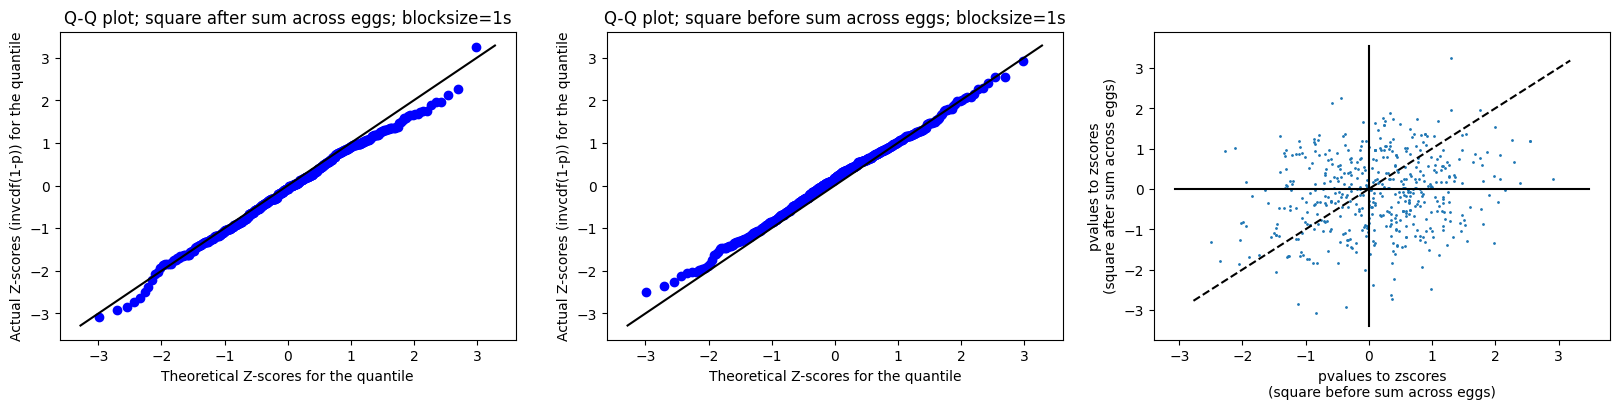

************TEST TYPE: controltimeshift_2
Meta-analysis Z-score if squaring *after* summing: 0.06846710125324822 pval: 0.47270690399848125
Meta-analysis Z-score if squaring *before* summing 4.692044634962718 pval:  1.3524404685050229e-06
Argmax event for square after summing: ('376', 'William &amp Catherine', datetime.datetime(2011, 4, 29, 10, 0), datetime.datetime(2011, 4, 29, 15, 59, 59), 21600.0) 3.7297312617661484
Argmax event for square before summing: ('100', 'Astrid Lindgren Dies', datetime.datetime(2002, 1, 28, 11, 0), datetime.datetime(2002, 1, 28, 14, 59, 59), 14400.0) 3.7399698663781185
Correlation between the two scores: PearsonRResult(statistic=0.1843567620058815, pvalue=4.2568117667147174e-05)


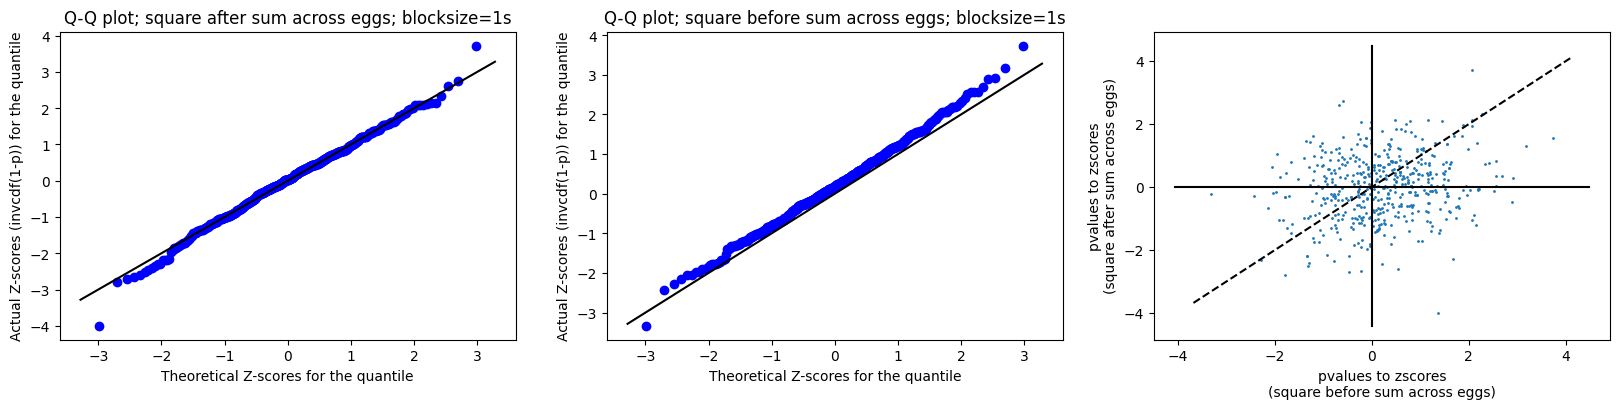

************TEST TYPE: controltimeshift_3
Meta-analysis Z-score if squaring *after* summing: 0.7240732347659898 pval: 0.23451038773441235
Meta-analysis Z-score if squaring *before* summing 5.329827703649067 pval:  4.915299245400462e-08
Argmax event for square after summing: ('196', 'Pope John Paul Dies', datetime.datetime(2005, 4, 2, 4, 0), datetime.datetime(2005, 4, 2, 23, 59, 59), 72000.0) 2.724387533103924
Argmax event for square before summing: ('376', 'William &amp Catherine', datetime.datetime(2011, 4, 29, 10, 0), datetime.datetime(2011, 4, 29, 15, 59, 59), 21600.0) 3.6267209733501846
Correlation between the two scores: PearsonRResult(statistic=0.172511939353444, pvalue=0.00013027140139376073)


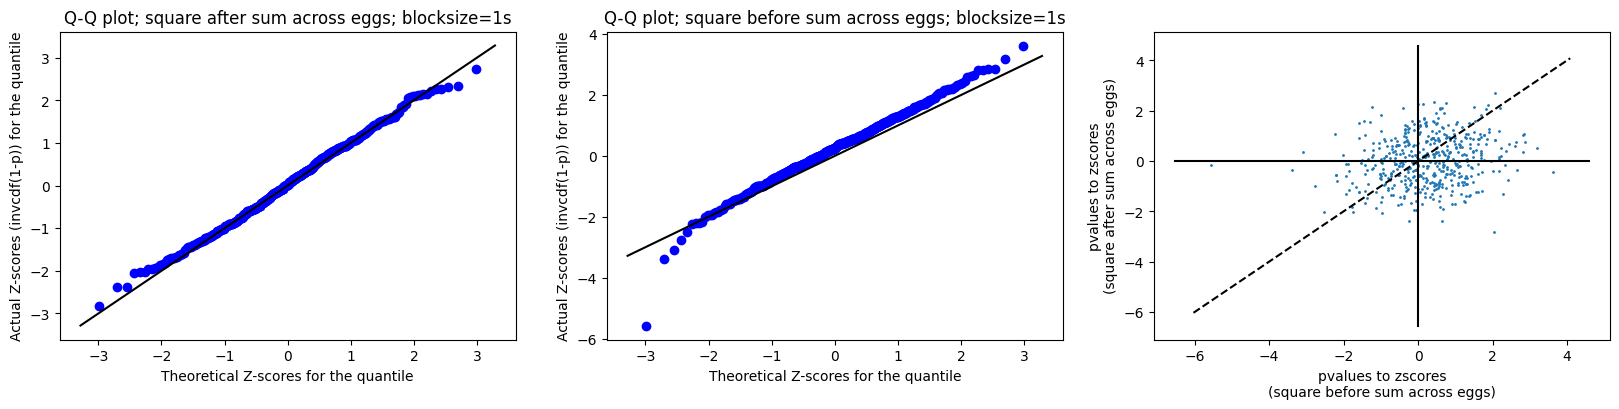




Blocksize: 2 seconds
************TEST TYPE: actual
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 3.5561174447215556 pval: 0.00018818793785624344
Meta-analysis Z-score if squaring *before* summing 5.386829041405572 pval:  3.585579233522651e-08
Argmax event for square after summing: ('216', 'Earth Day, 2006', datetime.datetime(2006, 4, 22, 0, 0), datetime.datetime(2006, 4, 22, 23, 59, 59), 86400.0) 2.8536347510654143
Argmax event for square before summing: ('270', 'World Meditation 080816', datetime.datetime(2008, 8, 16, 10, 0), datetime.datetime(2008, 8, 16, 10, 59, 59), 3600.0) 2.8839907600209322
Correlation between the two scores: PearsonRResult(statistic=0.1632391451623392, pvalue=0.0003018884936137099)


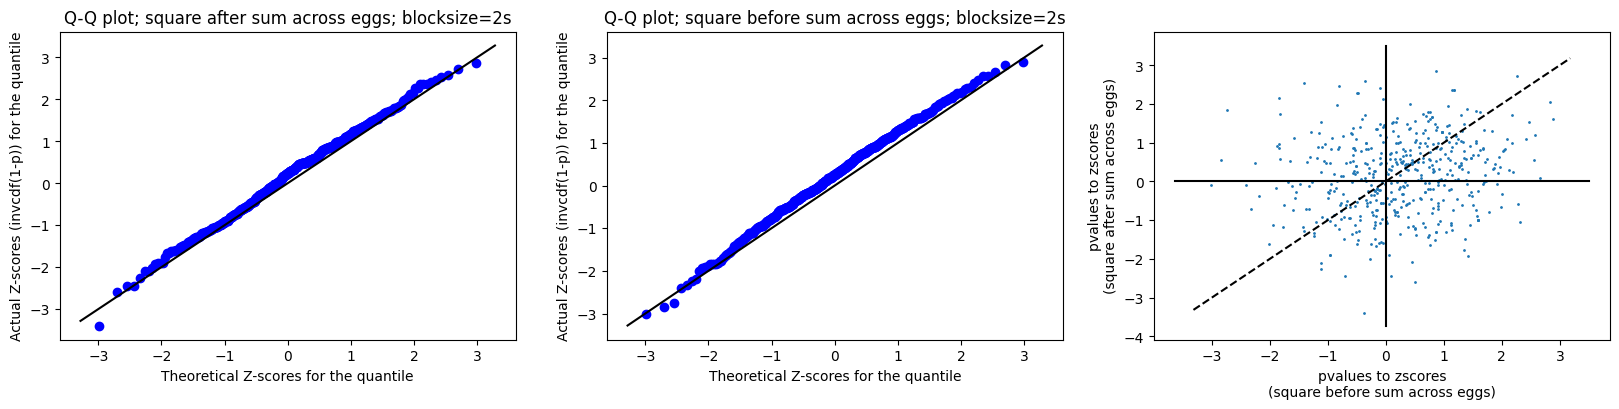

************TEST TYPE: controltimeshift_-3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.07019747923110592 pval: 0.4720182403300367
Meta-analysis Z-score if squaring *before* summing 3.025271435747467 pval:  0.001242050403043149
Argmax event for square after summing: ('24', 'Dow Tops 10000', datetime.datetime(1999, 3, 29, 20, 0), datetime.datetime(1999, 3, 29, 21, 59, 59), 7200.0) 2.508641980452086
Argmax event for square before summing: ('46', 'Papal Visit, Israel', datetime.datetime(2000, 3, 21, 0, 0), datetime.datetime(2000, 3, 26, 23, 59, 59), 518400.0) 3.1870112595083393
Correlation between the two scores: PearsonRResult(statistic=0.1626495012328995, pvalue=0.0003176741912047278)


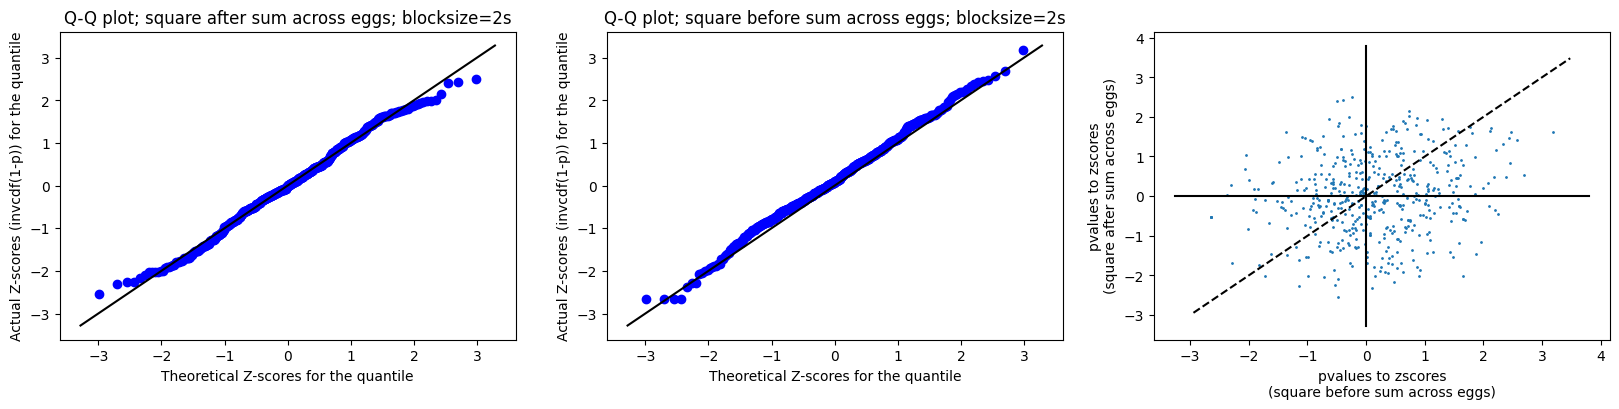

************TEST TYPE: controltimeshift_-2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.05713631565947677 pval: 0.4772183039744079
Meta-analysis Z-score if squaring *before* summing 4.285805167831639 pval:  9.103925641573696e-06
Argmax event for square after summing: ('55', 'Group Mind Meditation', datetime.datetime(2000, 9, 24, 22, 0), datetime.datetime(2000, 9, 24, 22, 59, 59), 3600.0) 3.3734096198663788
Argmax event for square before summing: ('53', 'Peace Summit Relig Spirit', datetime.datetime(2000, 8, 28, 0, 0), datetime.datetime(2000, 8, 31, 23, 59, 59), 345600.0) 3.33904820457536
Correlation between the two scores: PearsonRResult(statistic=0.1951570100853084, pvalue=1.4711195453490803e-05)


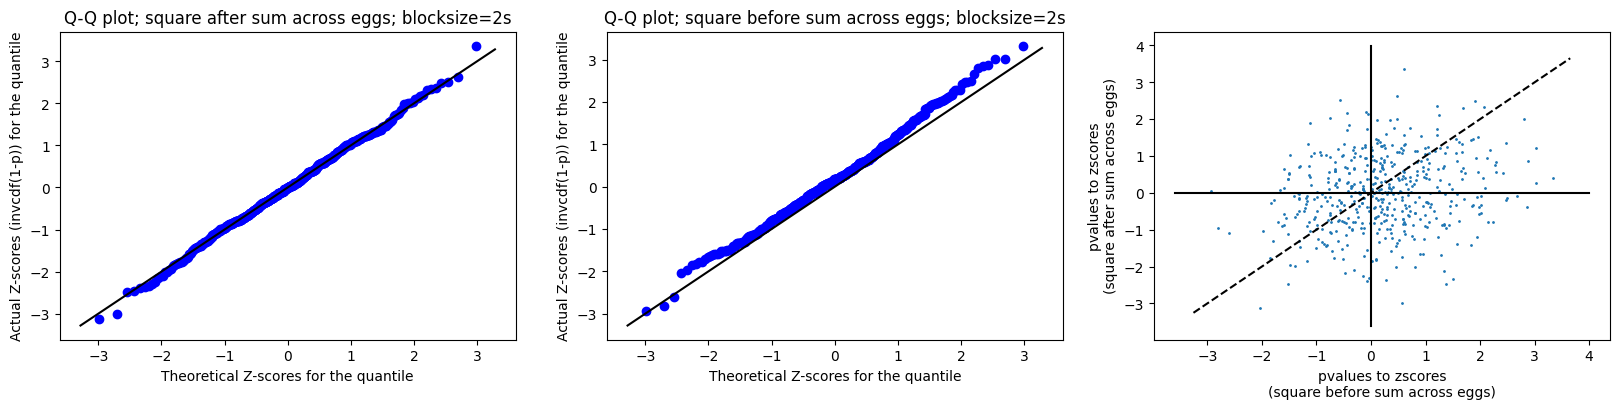

************TEST TYPE: controltimeshift_-1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.14122045944089193 pval: 0.5561521081246587
Meta-analysis Z-score if squaring *before* summing 2.4510872013589244 pval:  0.007121272239035692
Argmax event for square after summing: ('297', 'Air France Disappearance', datetime.datetime(2009, 5, 31, 22, 0), datetime.datetime(2009, 6, 1, 5, 59, 59), 28800.0) 3.1778410196900677
Argmax event for square before summing: ('130', 'Peace Meditation', datetime.datetime(2003, 2, 9, 17, 0), datetime.datetime(2003, 2, 9, 17, 59, 59), 3600.0) 2.815651156617505
Correlation between the two scores: PearsonRResult(statistic=0.15950891693130761, pvalue=0.00041554322425552565)


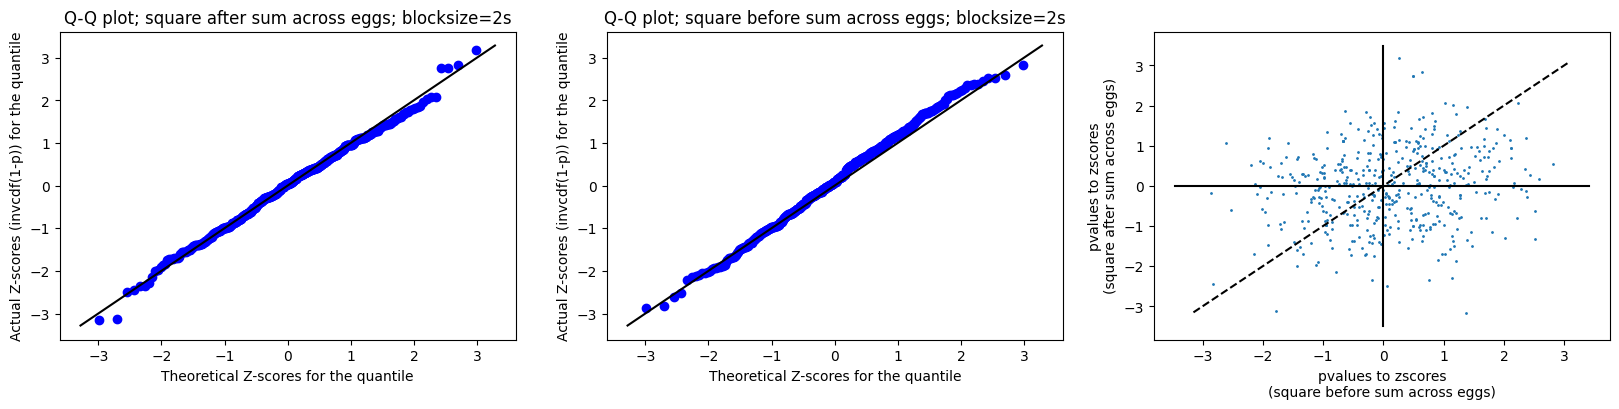

************TEST TYPE: controltimeshift_1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -1.437991950994385 pval: 0.924781831027846
Meta-analysis Z-score if squaring *before* summing 1.5767558441131042 pval:  0.057425857672065095
Argmax event for square after summing: ('452', 'Bangladesh Factory Collapse', datetime.datetime(2013, 4, 24, 3, 0), datetime.datetime(2013, 4, 24, 8, 59, 59), 21600.0) 2.741751042891698
Argmax event for square before summing: ('413', 'Mogadishu Bombing', datetime.datetime(2012, 4, 4, 9, 0), datetime.datetime(2012, 4, 4, 14, 59, 59), 21600.0) 2.8341108661417036
Correlation between the two scores: PearsonRResult(statistic=0.12724831995547634, pvalue=0.004962679863394126)


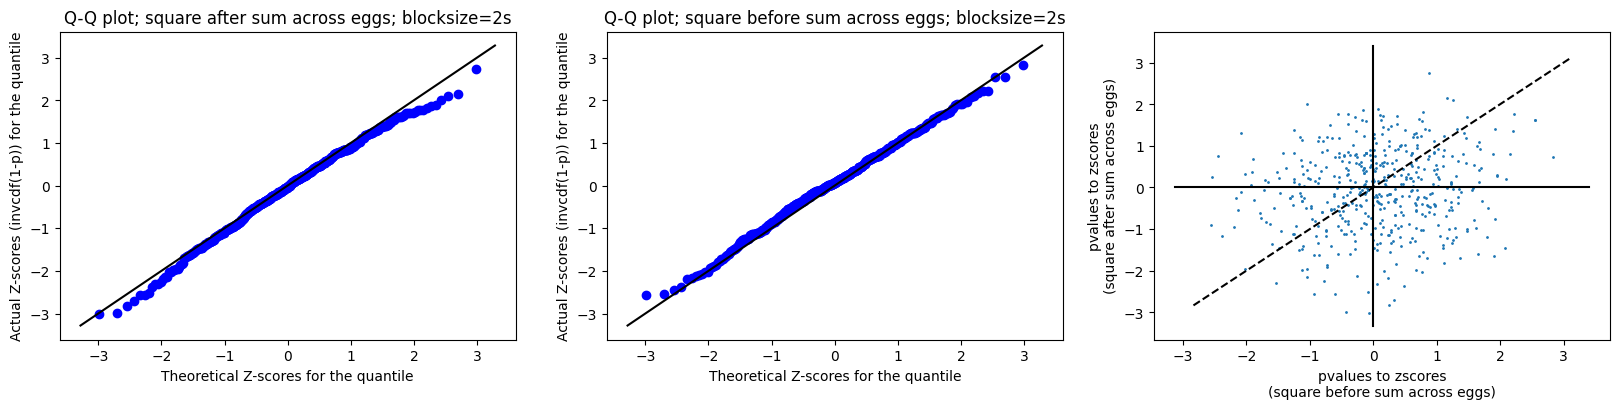

************TEST TYPE: controltimeshift_2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.19069163825700802 pval: 0.5756164049075277
Meta-analysis Z-score if squaring *before* summing 3.836008982774416 pval:  6.252491792069215e-05
Argmax event for square after summing: ('375', 'Sai Baba Dies', datetime.datetime(2011, 4, 24, 1, 30), datetime.datetime(2011, 4, 24, 7, 29, 59), 21600.0) 2.9744808931000706
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 3.3738834604230217
Correlation between the two scores: PearsonRResult(statistic=0.18761024863030656, pvalue=3.150448787336798e-05)


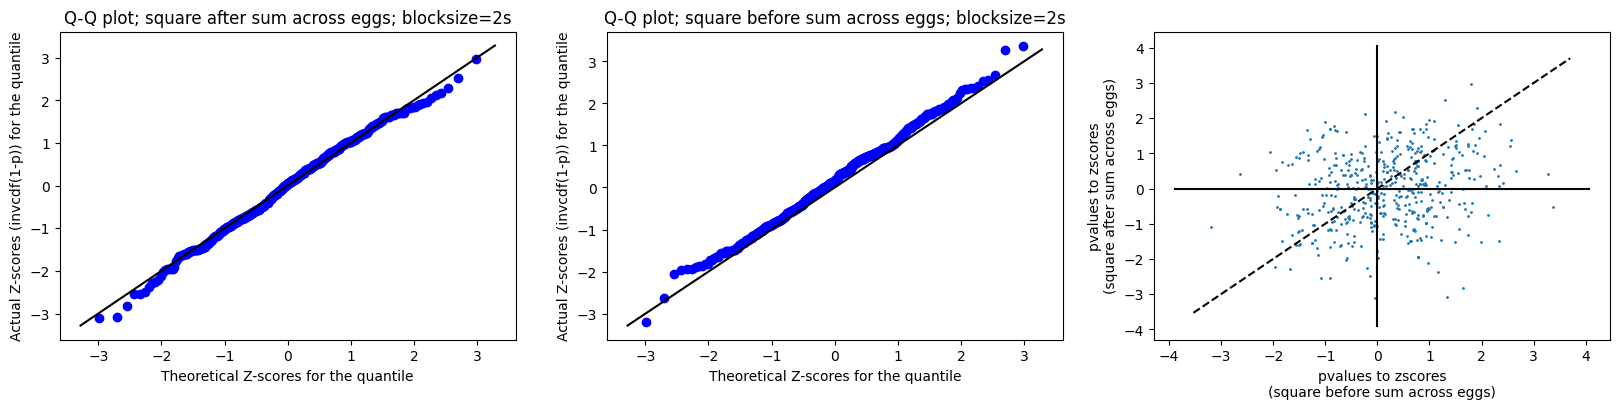

************TEST TYPE: controltimeshift_3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.0275834775153692 pval: 0.1520728997836639
Meta-analysis Z-score if squaring *before* summing 4.760064830052446 pval:  9.676539222125413e-07
Argmax event for square after summing: ('488', 'Ottowa Terror Shooting', datetime.datetime(2014, 9, 22, 14, 0), datetime.datetime(2014, 9, 22, 19, 59, 59), 21600.0) 3.2475235891716223
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 7.552700183650687
Correlation between the two scores: PearsonRResult(statistic=0.24007265193770508, pvalue=8.442000674945632e-08)


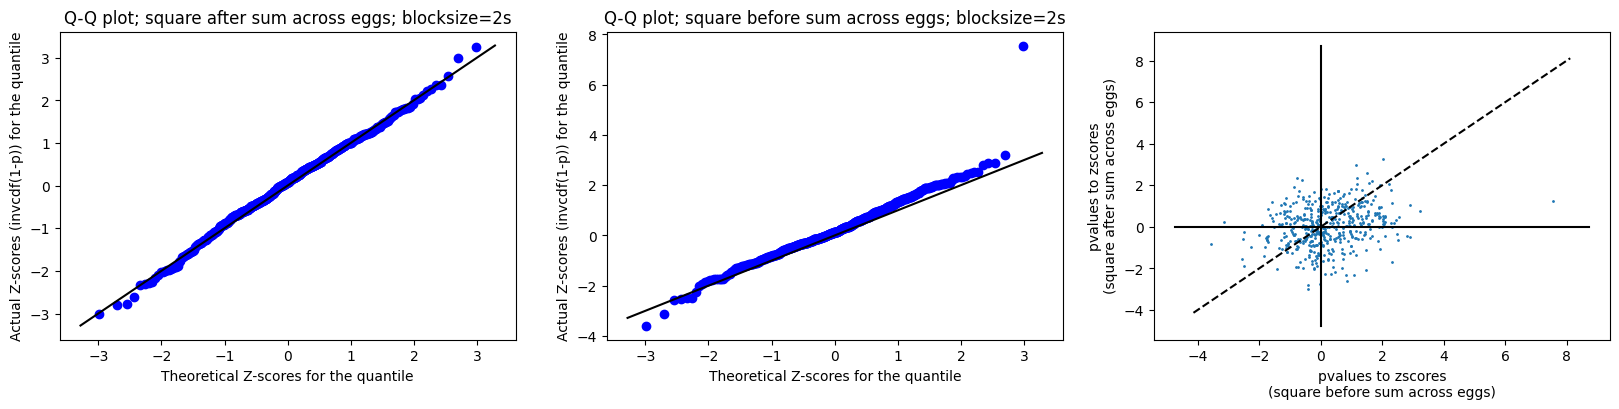




Blocksize: 3 seconds
************TEST TYPE: actual
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 2.9252885284539705 pval: 0.0017206849239864708
Meta-analysis Z-score if squaring *before* summing 5.530167903704901 pval:  1.599622112546939e-08
Argmax event for square after summing: ('208', 'India Bombs', datetime.datetime(2005, 10, 29, 11, 8), datetime.datetime(2005, 10, 29, 16, 7, 59), 18000.0) 2.891194279937418
Argmax event for square before summing: ('256', 'New Year Mean, 2008', datetime.datetime(2007, 12, 31, 9, 30), datetime.datetime(2008, 1, 1, 12, 29, 59), 97200.0) 3.0604074389762403
Correlation between the two scores: PearsonRResult(statistic=0.17644584046392459, pvalue=9.209494213567221e-05)


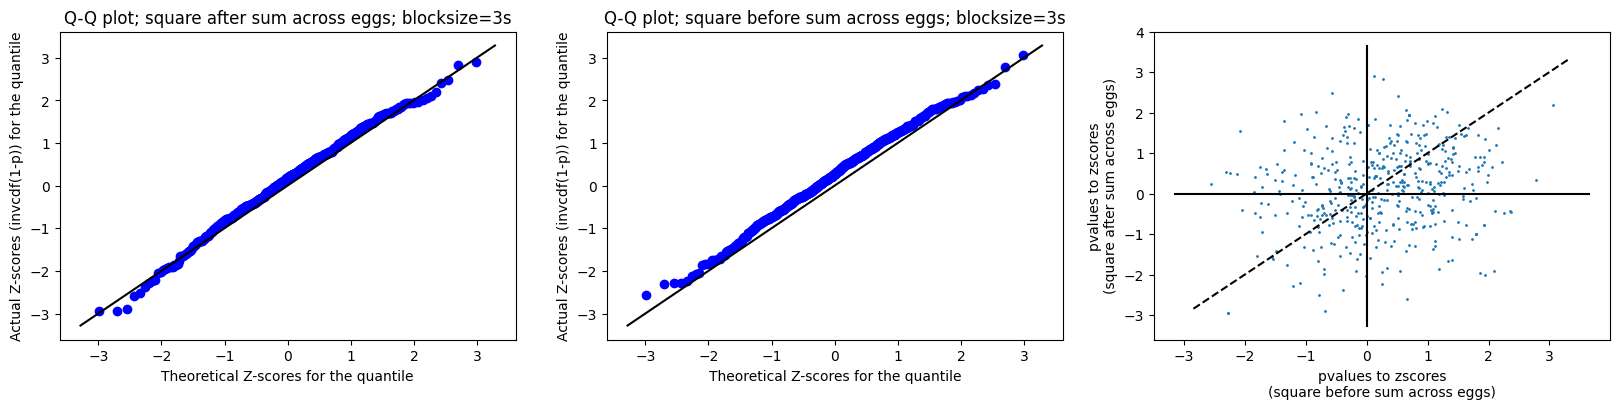

************TEST TYPE: controltimeshift_-3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.38876560627571144 pval: 0.34872477275472047
Meta-analysis Z-score if squaring *before* summing 2.5863966175291915 pval:  0.004849262986902025
Argmax event for square after summing: ('342', 'Ending Iraq War', datetime.datetime(2010, 8, 31, 23, 30), datetime.datetime(2010, 9, 1, 1, 29, 59), 7200.0) 3.076074144087085
Argmax event for square before summing: ('505', 'Charleston Hate Crime', datetime.datetime(2015, 5, 18, 0, 0), datetime.datetime(2015, 5, 18, 7, 59, 59), 28800.0) 3.3281458385570617
Correlation between the two scores: PearsonRResult(statistic=0.1639554334172389, pvalue=0.0002836976736621467)


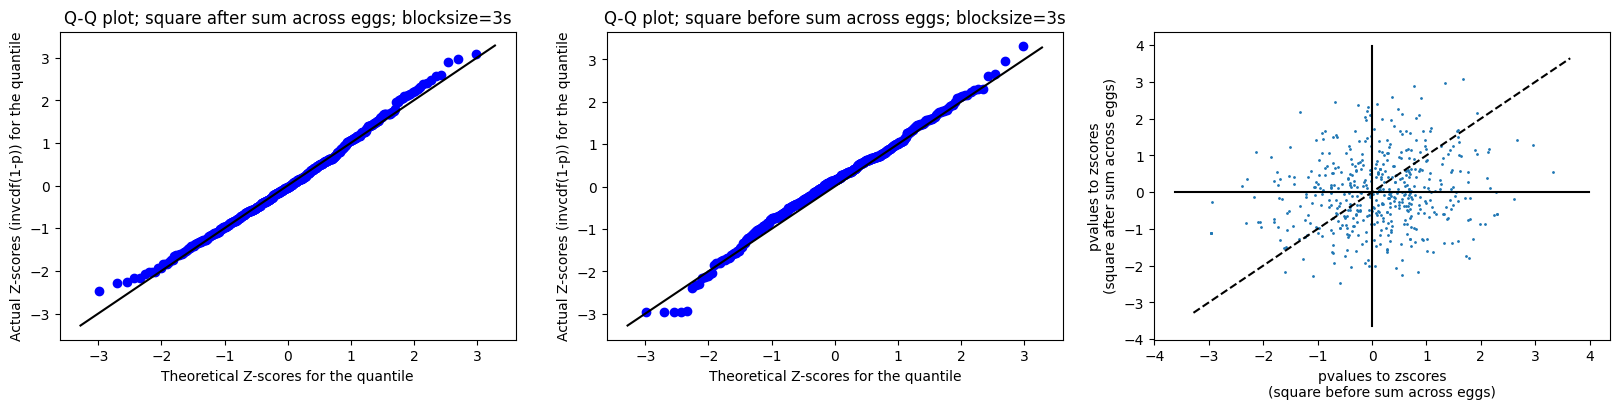

************TEST TYPE: controltimeshift_-2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.017804777430583094 pval: 0.5071027032367711
Meta-analysis Z-score if squaring *before* summing 4.207333665860915 pval:  1.2920073451661018e-05
Argmax event for square after summing: ('216', 'Earth Day, 2006', datetime.datetime(2006, 4, 22, 0, 0), datetime.datetime(2006, 4, 22, 23, 59, 59), 86400.0) 2.7647247402180013
Argmax event for square before summing: ('192', 'Elections in Iraq', datetime.datetime(2005, 1, 30, 4, 0), datetime.datetime(2005, 1, 30, 15, 59, 59), 43200.0) 3.403720501083869
Correlation between the two scores: PearsonRResult(statistic=0.13191368179687488, pvalue=0.0035758110746463025)


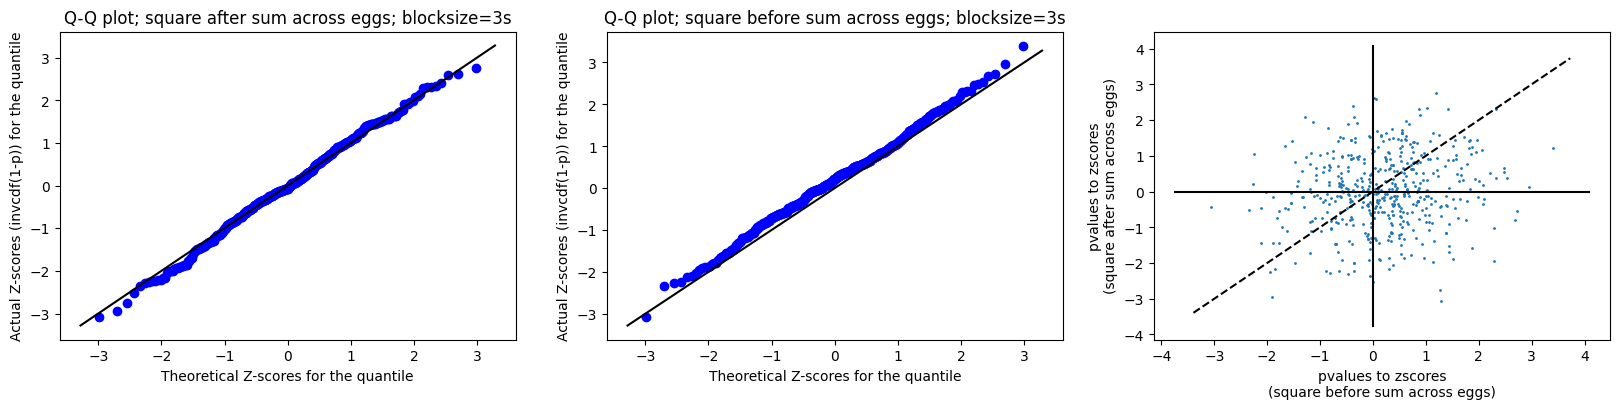

************TEST TYPE: controltimeshift_-1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.5129753217174844 pval: 0.6960157082521179
Meta-analysis Z-score if squaring *before* summing 1.975814438845875 pval:  0.02408789874969619
Argmax event for square after summing: ('50', 'Kursk Tragedy, 30-min', datetime.datetime(2000, 8, 12, 7, 28), datetime.datetime(2000, 8, 12, 7, 57, 59), 1800.0) 2.484391546601976
Argmax event for square before summing: ('53', 'Peace Summit Relig Spirit', datetime.datetime(2000, 8, 28, 0, 0), datetime.datetime(2000, 8, 31, 23, 59, 59), 345600.0) 3.305567102906455
Correlation between the two scores: PearsonRResult(statistic=0.12018730108713978, pvalue=0.007992749793491988)


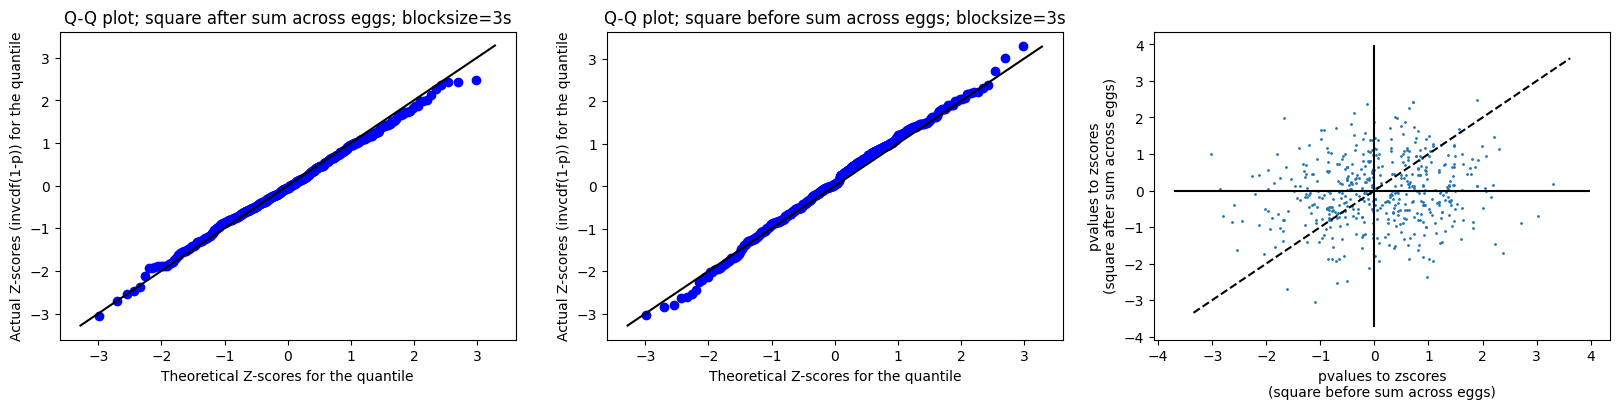

************TEST TYPE: controltimeshift_1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.4303415854340828 pval: 0.666526409546399
Meta-analysis Z-score if squaring *before* summing 1.6569580142291038 pval:  0.04876398195542475
Argmax event for square after summing: ('268', 'Olympic Opening Beijing', datetime.datetime(2008, 8, 8, 12, 0), datetime.datetime(2008, 8, 8, 15, 59, 59), 14400.0) 3.236071823523615
Argmax event for square before summing: ('374', 'Earth Day, 2011', datetime.datetime(2011, 4, 22, 0, 0), datetime.datetime(2011, 4, 22, 23, 59, 59), 86400.0) 3.3003392700772727
Correlation between the two scores: PearsonRResult(statistic=0.1923029797588678, pvalue=1.9689446175513986e-05)


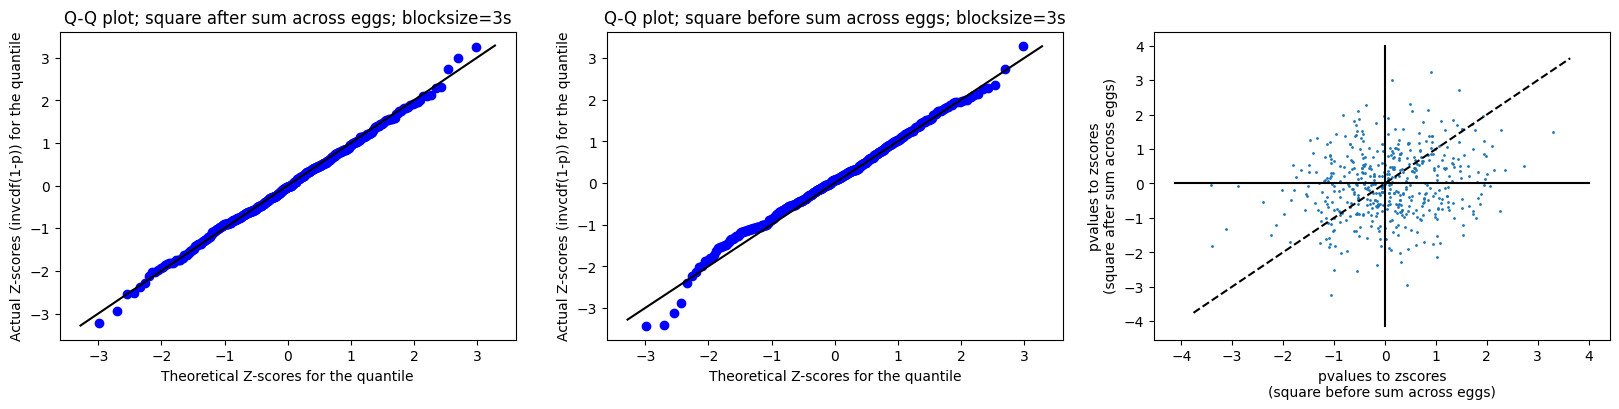

************TEST TYPE: controltimeshift_2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.6504758366835747 pval: 0.7423075475208347
Meta-analysis Z-score if squaring *before* summing 3.9226857617383204 pval:  4.378366515700449e-05
Argmax event for square after summing: ('375', 'Sai Baba Dies', datetime.datetime(2011, 4, 24, 1, 30), datetime.datetime(2011, 4, 24, 7, 29, 59), 21600.0) 3.142947350473949
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 3.358989874129537
Correlation between the two scores: PearsonRResult(statistic=0.1435705716153307, pvalue=0.0015067695188385527)


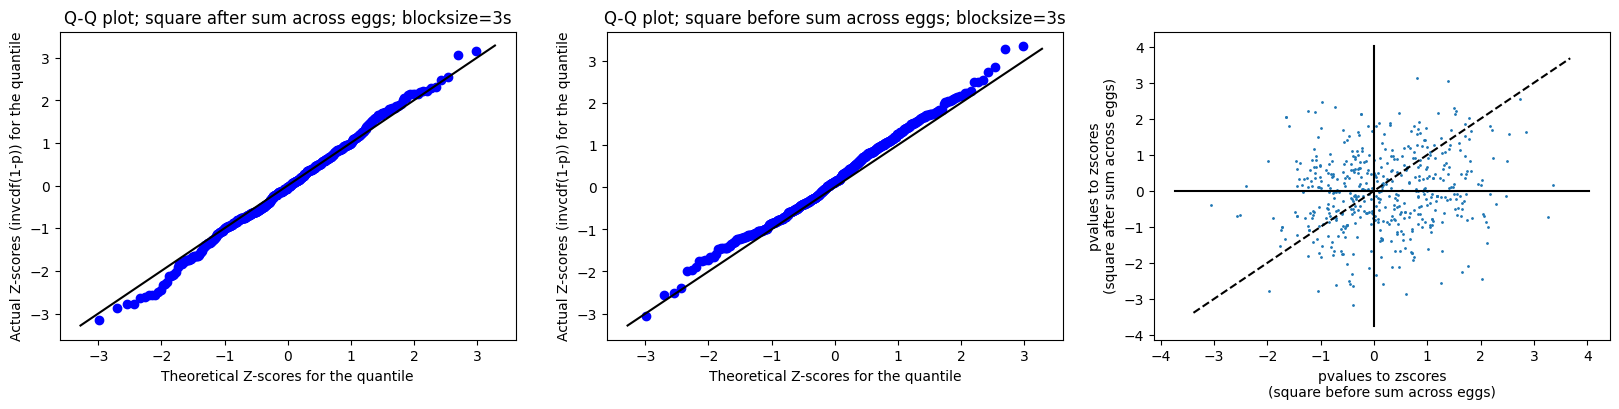

************TEST TYPE: controltimeshift_3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.023938301673941374 pval: 0.5095490886447647
Meta-analysis Z-score if squaring *before* summing 3.161436234658757 pval:  0.0007849659359954186
Argmax event for square after summing: ('93', 'World Puja Meditation', datetime.datetime(2001, 11, 16, 17, 0), datetime.datetime(2001, 11, 16, 17, 29, 59), 1800.0) 2.4652633611550026
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 11.202739709000623
Correlation between the two scores: PearsonRResult(statistic=0.26463127925554936, pvalue=3.1261963635316147e-09)


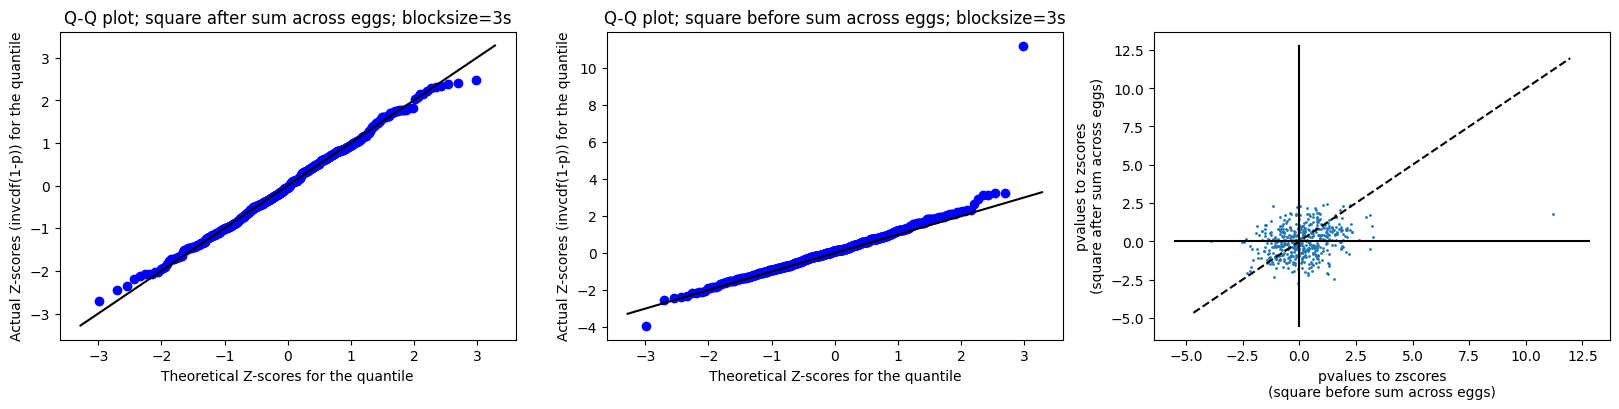




Blocksize: 6 seconds
************TEST TYPE: actual
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 2.66962652124544 pval: 0.003796782921948294
Meta-analysis Z-score if squaring *before* summing 3.2993864071808 pval:  0.00048448216906349373
Argmax event for square after summing: ('320', 'Haiti Earthquake', datetime.datetime(2010, 1, 12, 20, 0), datetime.datetime(2010, 1, 13, 3, 59, 59), 28800.0) 2.8309505261170873
Argmax event for square before summing: ('73', 'Earth Day, 2001', datetime.datetime(2001, 4, 22, 0, 0), datetime.datetime(2001, 4, 22, 23, 59, 59), 86400.0) 4.0092378700332825
Correlation between the two scores: PearsonRResult(statistic=0.17923139781473021, pvalue=7.089154321926082e-05)


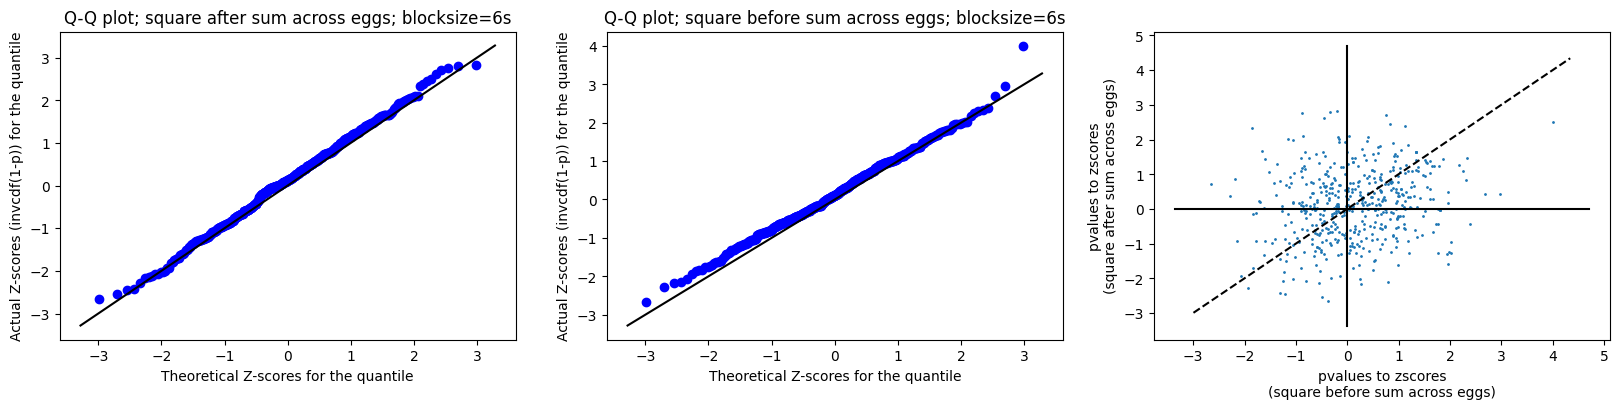

************TEST TYPE: controltimeshift_-3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.5963346999676368 pval: 0.724524172852144
Meta-analysis Z-score if squaring *before* summing 1.81995694196588 pval:  0.03438278115403315
Argmax event for square after summing: ('198', "Prince Charles' Wedding", datetime.datetime(2005, 4, 9, 11, 0), datetime.datetime(2005, 4, 9, 14, 59, 59), 14400.0) 3.119946128882596
Argmax event for square before summing: ('407', 'SOPA Protests, Withdrawal', datetime.datetime(2012, 1, 20, 18, 0), datetime.datetime(2012, 1, 20, 23, 59, 59), 21600.0) 3.1291340144049005
Correlation between the two scores: PearsonRResult(statistic=0.12913819376303967, pvalue=0.004351046916926147)


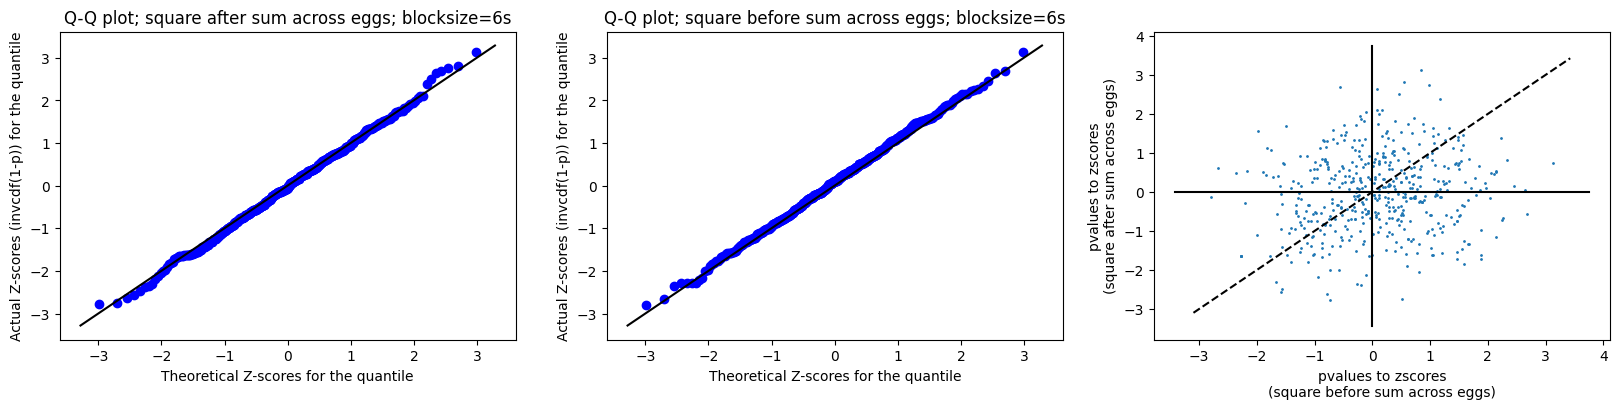

************TEST TYPE: controltimeshift_-2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.9647619084680024 pval: 0.8326679605173672
Meta-analysis Z-score if squaring *before* summing 2.9709404478607615 pval:  0.0014844467243342319
Argmax event for square after summing: ('129', 'Shuttle Columbia Disaster', datetime.datetime(2003, 2, 1, 13, 0), datetime.datetime(2003, 2, 1, 16, 59, 59), 14400.0) 2.9355852104201072
Argmax event for square before summing: ('293', 'Italian Quake', datetime.datetime(2009, 4, 6, 0, 0), datetime.datetime(2009, 4, 6, 11, 59, 59), 43200.0) 2.9799335057025775
Correlation between the two scores: PearsonRResult(statistic=0.1819243989993207, pvalue=5.4839641014155196e-05)


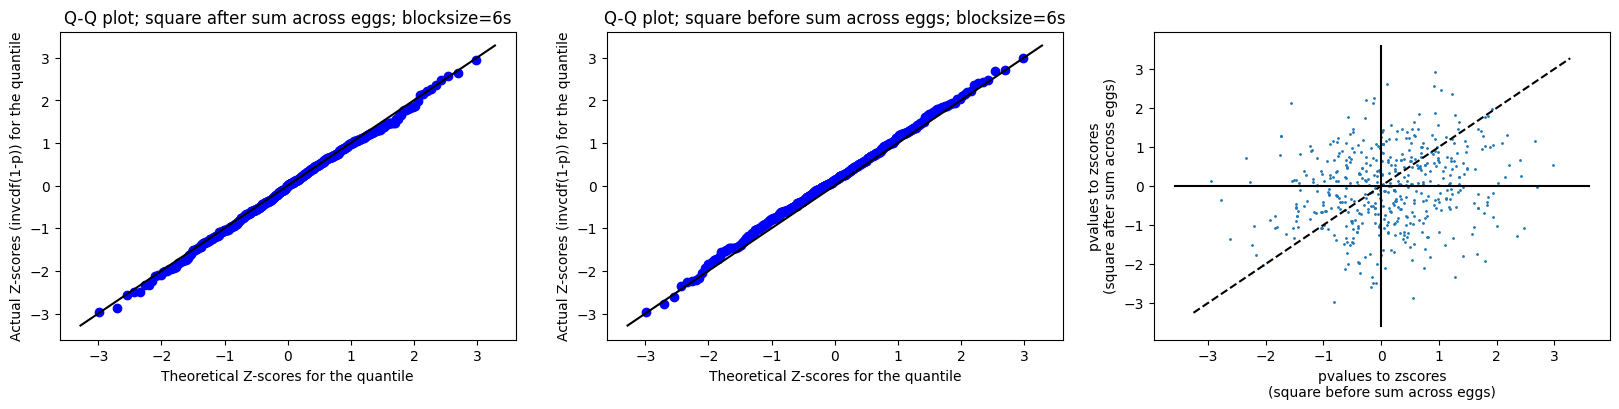

************TEST TYPE: controltimeshift_-1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -1.0946759737536935 pval: 0.8631706909174064
Meta-analysis Z-score if squaring *before* summing 1.2237578241334741 pval:  0.11052179948914698
Argmax event for square after summing: ('349', 'Indonesia, Quake, Volcano', datetime.datetime(2010, 10, 25, 14, 0), datetime.datetime(2010, 10, 26, 13, 59, 59), 86400.0) 2.831967561584433
Argmax event for square before summing: ('53', 'Peace Summit Relig Spirit', datetime.datetime(2000, 8, 28, 0, 0), datetime.datetime(2000, 8, 31, 23, 59, 59), 345600.0) 2.8367657398636217
Correlation between the two scores: PearsonRResult(statistic=0.14662097713744496, pvalue=0.0011888963489846576)


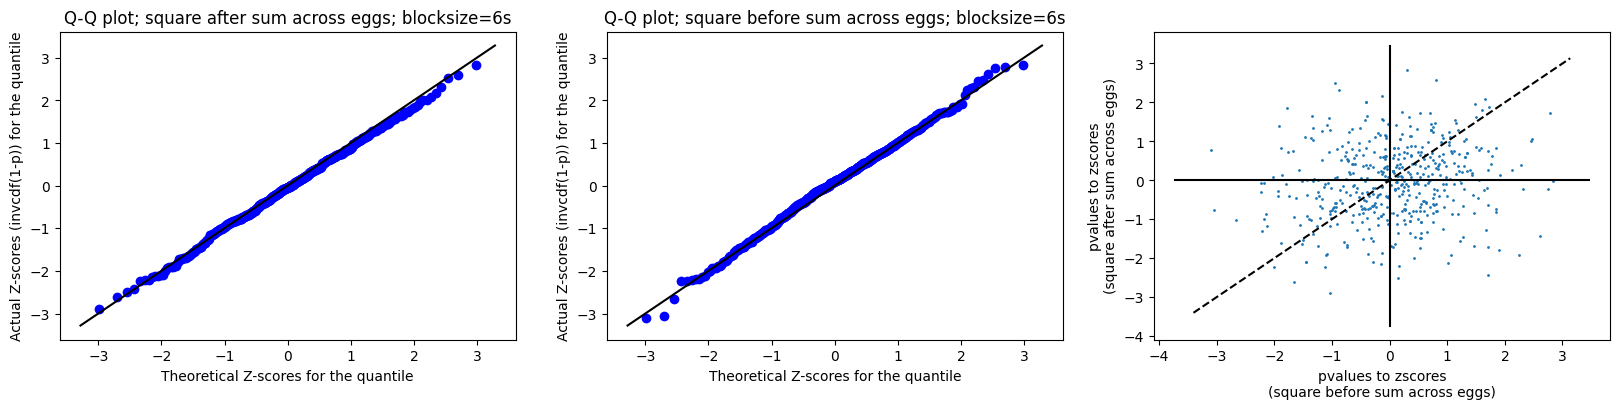

************TEST TYPE: controltimeshift_1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.2736097171496574 pval: 0.607807717166058
Meta-analysis Z-score if squaring *before* summing 2.021453730271347 pval:  0.021616408735450787
Argmax event for square after summing: ('231', 'New Year Mean 2006-2007', datetime.datetime(2006, 12, 31, 9, 30), datetime.datetime(2007, 1, 1, 12, 29, 59), 97200.0) 3.634468532308831
Argmax event for square before summing: ('83', 'Sea to Shining See', datetime.datetime(2001, 9, 22, 1, 0), datetime.datetime(2001, 9, 22, 2, 59, 59), 7200.0) 3.0353365620606962
Correlation between the two scores: PearsonRResult(statistic=0.1733787750160683, pvalue=0.00012228740005731402)


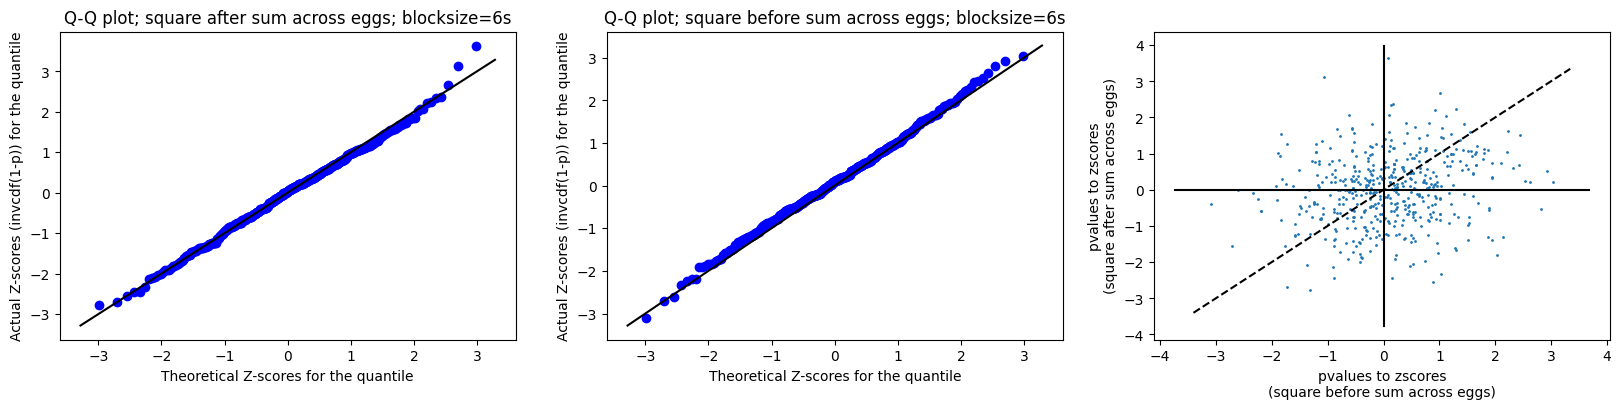

************TEST TYPE: controltimeshift_2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.2380133172879506 pval: 0.10785556146009645
Meta-analysis Z-score if squaring *before* summing 3.0892239203403573 pval:  0.0010034006210023483
Argmax event for square after summing: ('132', 'Korean Subway', datetime.datetime(2003, 2, 18, 0, 45), datetime.datetime(2003, 2, 18, 12, 44, 59), 43200.0) 2.892940510469991
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 6.690810425745599
Correlation between the two scores: PearsonRResult(statistic=0.15114694757018907, pvalue=0.0008295577432101082)


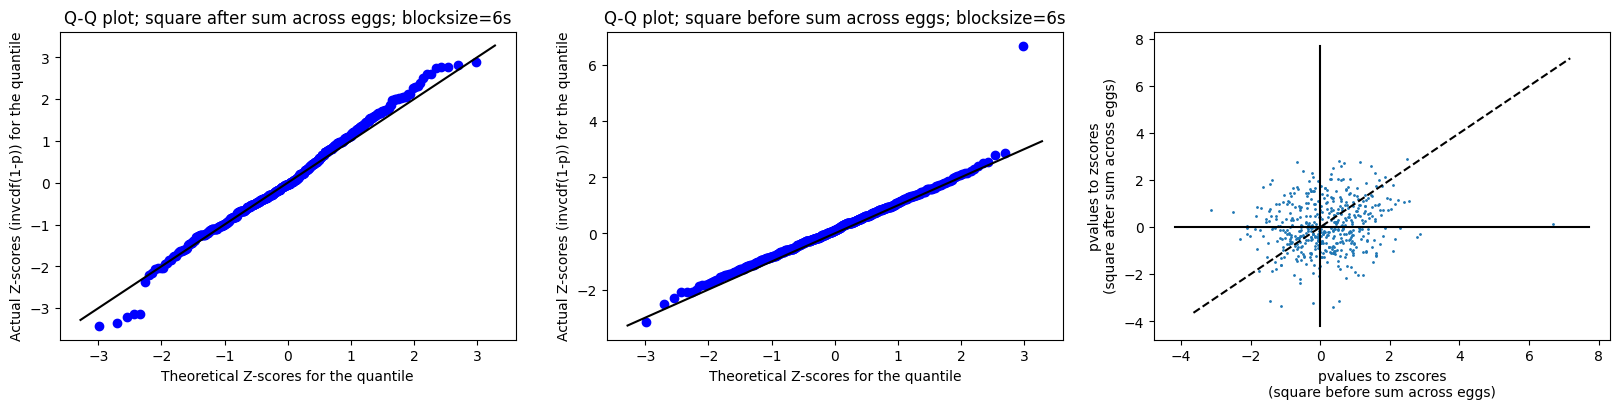

************TEST TYPE: controltimeshift_3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.2542587630603234 pval: 0.3996478277154061
Meta-analysis Z-score if squaring *before* summing 4.091483454790231 pval:  2.14311265410716e-05
Argmax event for square after summing: ('431', 'Obama Elected 2012', datetime.datetime(2012, 11, 6, 20, 0), datetime.datetime(2012, 11, 7, 19, 59, 59), 86400.0) 2.821421918110911
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 17.25915166841533
Correlation between the two scores: PearsonRResult(statistic=0.2624579990182362, pvalue=4.2441295269225946e-09)


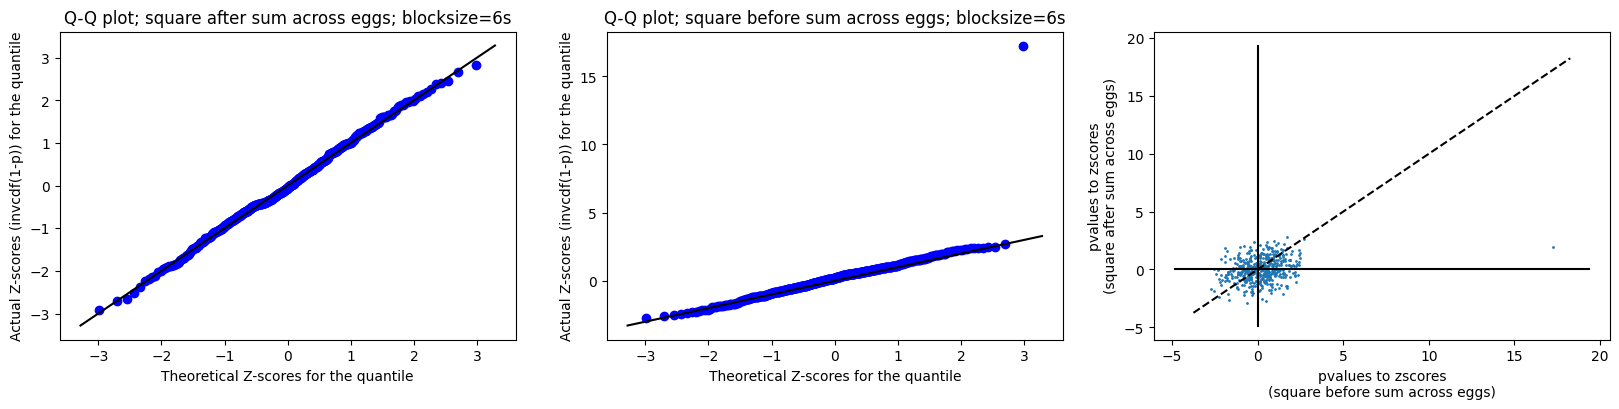




Blocksize: 8 seconds
************TEST TYPE: actual
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.7949877494238982 pval: 0.03632782589561545
Meta-analysis Z-score if squaring *before* summing 1.9203679475418198 pval:  0.027405719609355228
Argmax event for square after summing: ('173', 'Korean Train Explosion', datetime.datetime(2004, 4, 22, 3, 0), datetime.datetime(2004, 4, 22, 6, 59, 59), 14400.0) 2.868766153620809
Argmax event for square before summing: ('256', 'New Year Mean, 2008', datetime.datetime(2007, 12, 31, 9, 30), datetime.datetime(2008, 1, 1, 12, 29, 59), 97200.0) 3.9322841444815113
Correlation between the two scores: PearsonRResult(statistic=0.1607132586925008, pvalue=0.00037509469926590063)


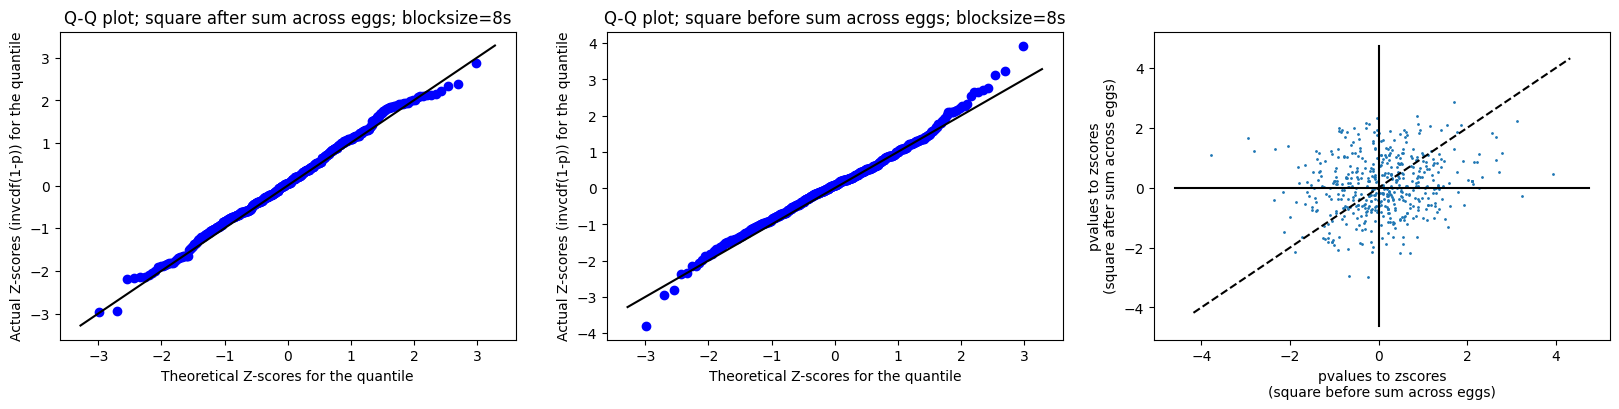

************TEST TYPE: controltimeshift_-3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.45656632221112203 pval: 0.3239913951741381
Meta-analysis Z-score if squaring *before* summing 2.507888355703637 pval:  0.006072751749523819
Argmax event for square after summing: ('133', 'Lysistrata', datetime.datetime(2003, 3, 3, 7, 0), datetime.datetime(2003, 3, 4, 6, 59, 59), 86400.0) 3.6065568350304638
Argmax event for square before summing: ('169', 'Demonstrations in Spain', datetime.datetime(2004, 3, 12, 11, 0), datetime.datetime(2004, 3, 12, 22, 59, 59), 43200.0) 3.0072124315635684
Correlation between the two scores: PearsonRResult(statistic=0.12314559628788697, pvalue=0.006564669256797708)


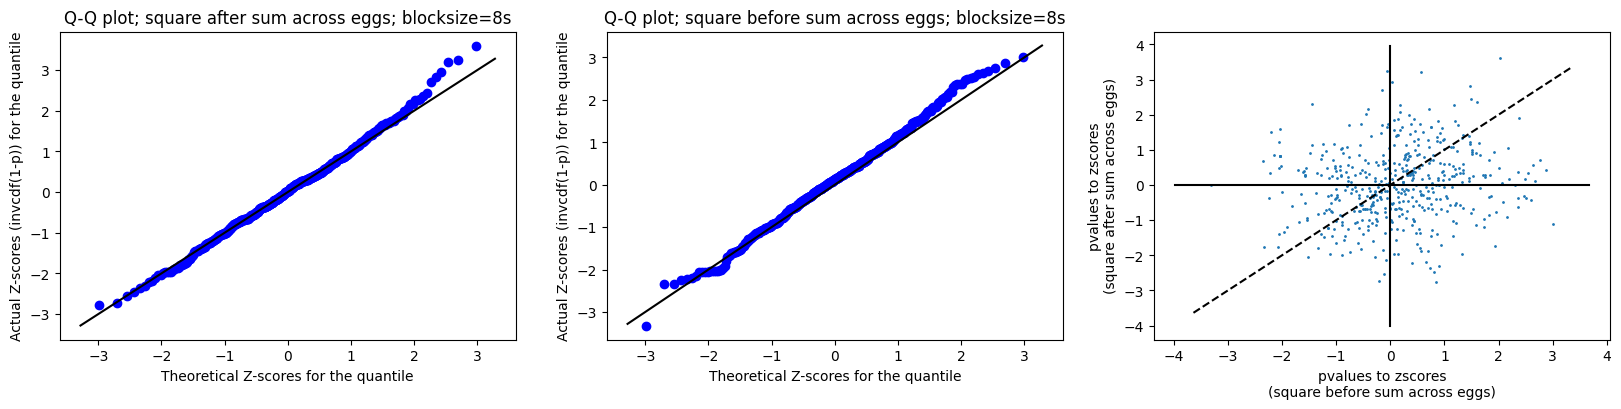

************TEST TYPE: controltimeshift_-2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.11795145035842 pval: 0.5469469368737572
Meta-analysis Z-score if squaring *before* summing 1.9094377056471297 pval:  0.02810282530057484
Argmax event for square after summing: ('346', 'International Day of Peace', datetime.datetime(2010, 9, 21, 0, 0), datetime.datetime(2010, 9, 21, 23, 59, 59), 86400.0) 2.9909941862021876
Argmax event for square before summing: ('484', 'Global Peace Meditation', datetime.datetime(2014, 8, 8, 16, 0), datetime.datetime(2014, 8, 8, 16, 59, 59), 3600.0) 3.1833770824722327
Correlation between the two scores: PearsonRResult(statistic=0.2083176054168452, pvalue=3.62976245534114e-06)


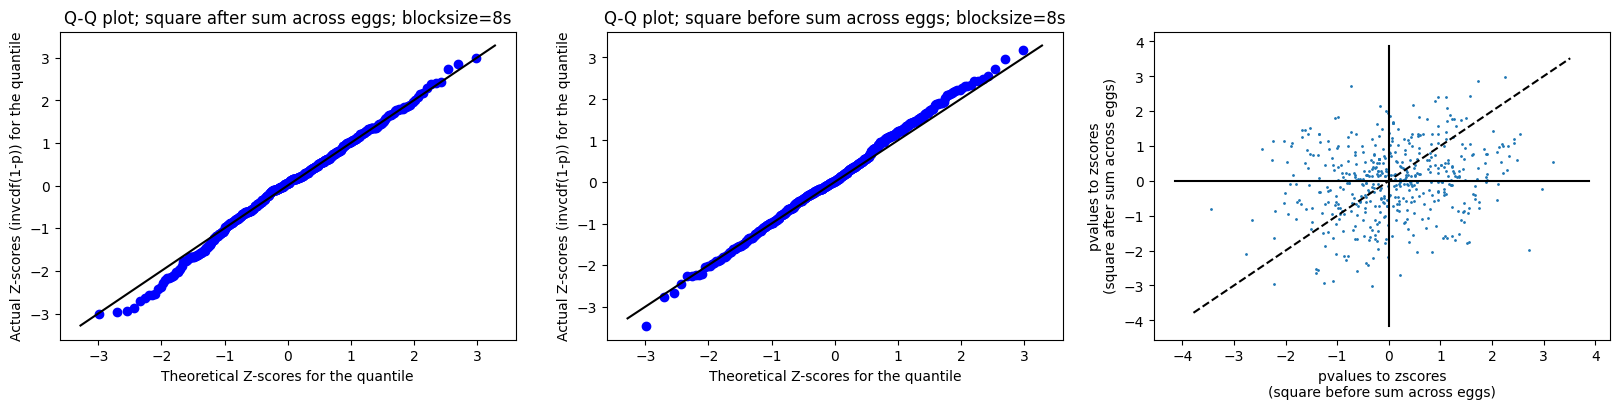

************TEST TYPE: controltimeshift_-1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -1.2344923528111864 pval: 0.8914902527236871
Meta-analysis Z-score if squaring *before* summing 0.191863603748261 pval:  0.42392452386720714
Argmax event for square after summing: ('390', 'Anniversary 911 2001', datetime.datetime(2011, 9, 11, 8, 0), datetime.datetime(2011, 9, 12, 1, 59, 59), 64800.0) 2.896084212938696
Argmax event for square before summing: ('221', 'Qana Lebanon', datetime.datetime(2006, 7, 30, 1, 0), datetime.datetime(2006, 7, 30, 5, 59, 59), 18000.0) 2.518742022185686
Correlation between the two scores: PearsonRResult(statistic=0.1669798572109993, pvalue=0.0002176030452202256)


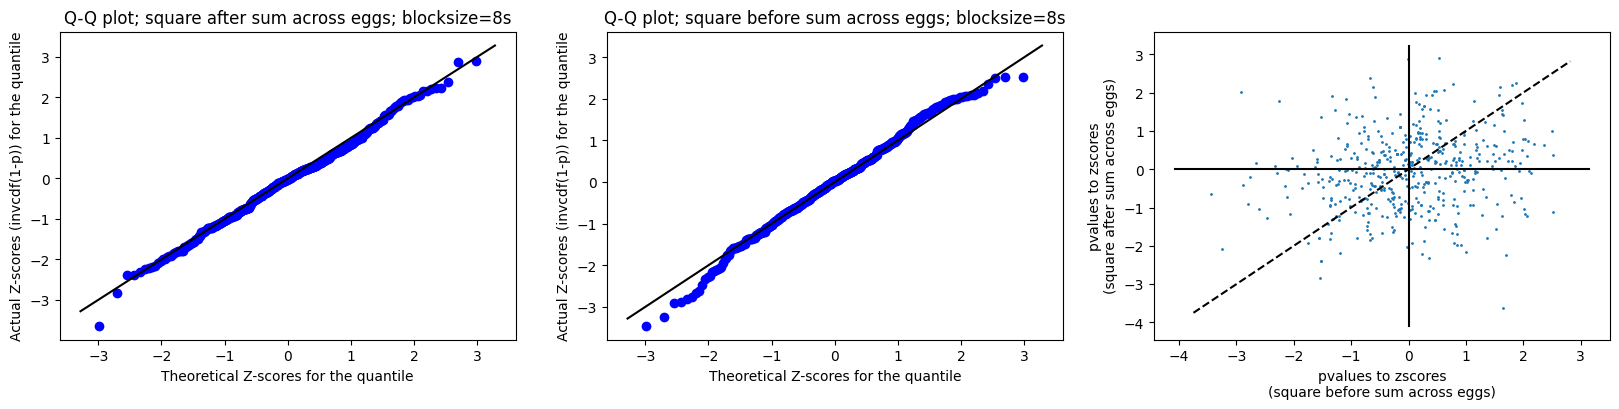

************TEST TYPE: controltimeshift_1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.552759950433516 pval: 0.7097861020293686
Meta-analysis Z-score if squaring *before* summing 1.3898207173166484 pval:  0.08229166270285249
Argmax event for square after summing: ('479', 'Landslide Afghanistan', datetime.datetime(2014, 5, 2, 7, 0), datetime.datetime(2014, 5, 3, 6, 59, 59), 86400.0) 3.0284926499721405
Argmax event for square before summing: ('446', 'Hugo Chavez Dies', datetime.datetime(2013, 3, 5, 20, 25), datetime.datetime(2013, 3, 6, 4, 24, 59), 28800.0) 2.7915655319406683
Correlation between the two scores: PearsonRResult(statistic=0.08563108697947587, pvalue=0.059244148356309055)


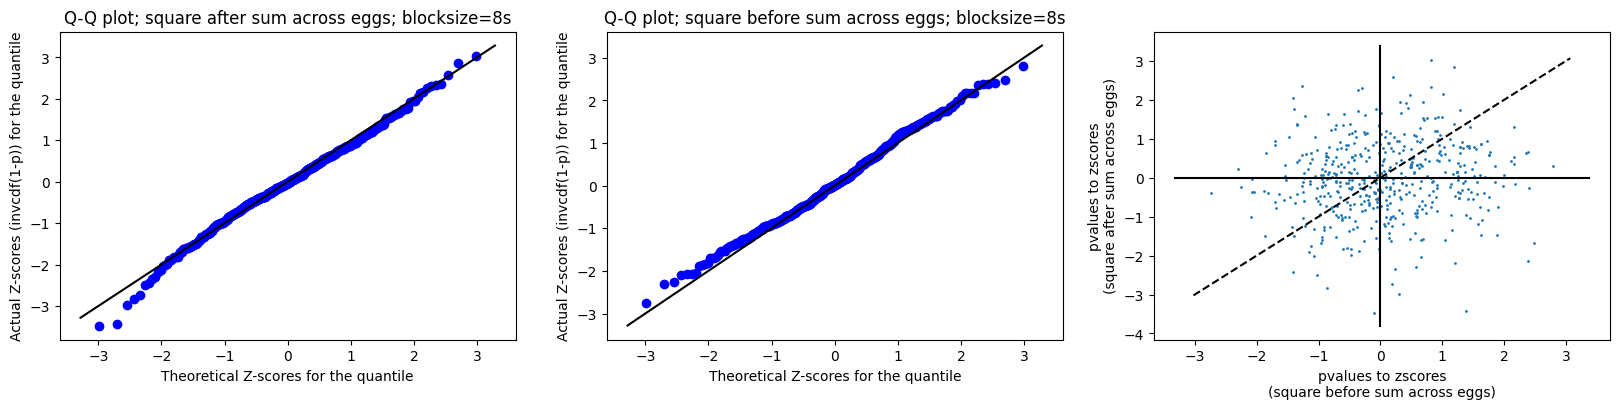

************TEST TYPE: controltimeshift_2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.781477357780934 pval: 0.21726089433679108
Meta-analysis Z-score if squaring *before* summing 1.7127640925297252 pval:  0.04337797427587464
Argmax event for square after summing: ('132', 'Korean Subway', datetime.datetime(2003, 2, 18, 0, 45), datetime.datetime(2003, 2, 18, 12, 44, 59), 43200.0) 3.626844757865621
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 7.886466703805941
Correlation between the two scores: PearsonRResult(statistic=0.13751490908236205, pvalue=0.0023798672693885223)


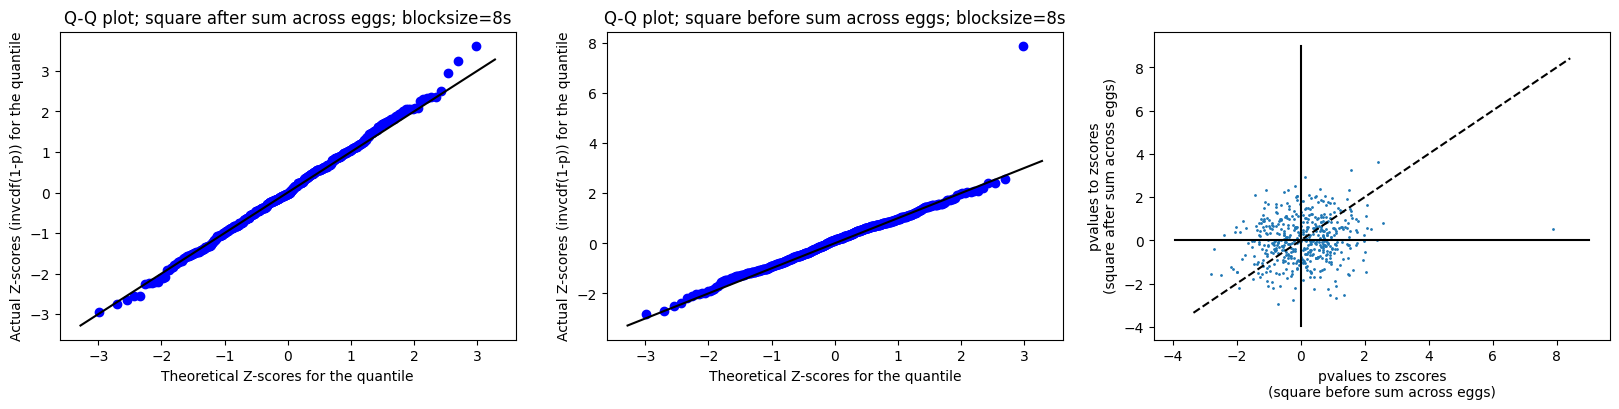

************TEST TYPE: controltimeshift_3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.378065966920931 pval: 0.08409146099217057
Meta-analysis Z-score if squaring *before* summing 5.036577638581282 pval:  2.3696446616039424e-07
Argmax event for square after summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 4.040316190101327
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 20.217612532419782
Correlation between the two scores: PearsonRResult(statistic=0.26895108444328136, pvalue=1.6886069096078733e-09)


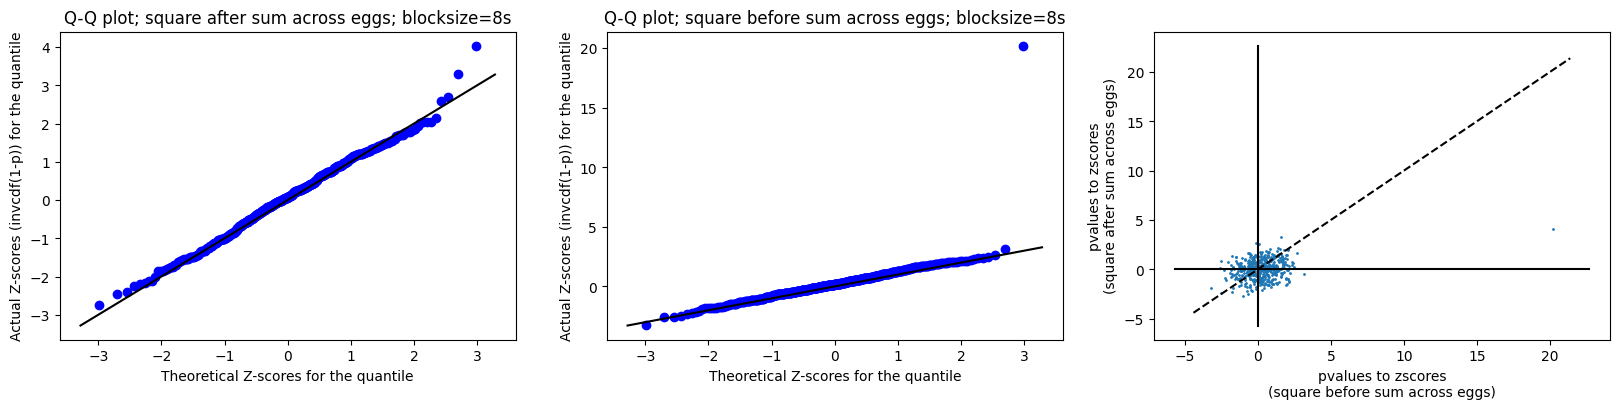




Blocksize: 10 seconds
************TEST TYPE: actual
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.6178744494047563 pval: 0.05284482883843955
Meta-analysis Z-score if squaring *before* summing 2.3828028482626613 pval:  0.008590696563892442
Argmax event for square after summing: ('89', 'World Series, Yankee Stadium', datetime.datetime(2001, 11, 1, 0, 0), datetime.datetime(2001, 11, 1, 4, 59, 59), 18000.0) 3.29727774692361
Argmax event for square before summing: ('256', 'New Year Mean, 2008', datetime.datetime(2007, 12, 31, 9, 30), datetime.datetime(2008, 1, 1, 12, 29, 59), 97200.0) 3.2858793279659446
Correlation between the two scores: PearsonRResult(statistic=0.13481735386652227, pvalue=0.002900819989553157)


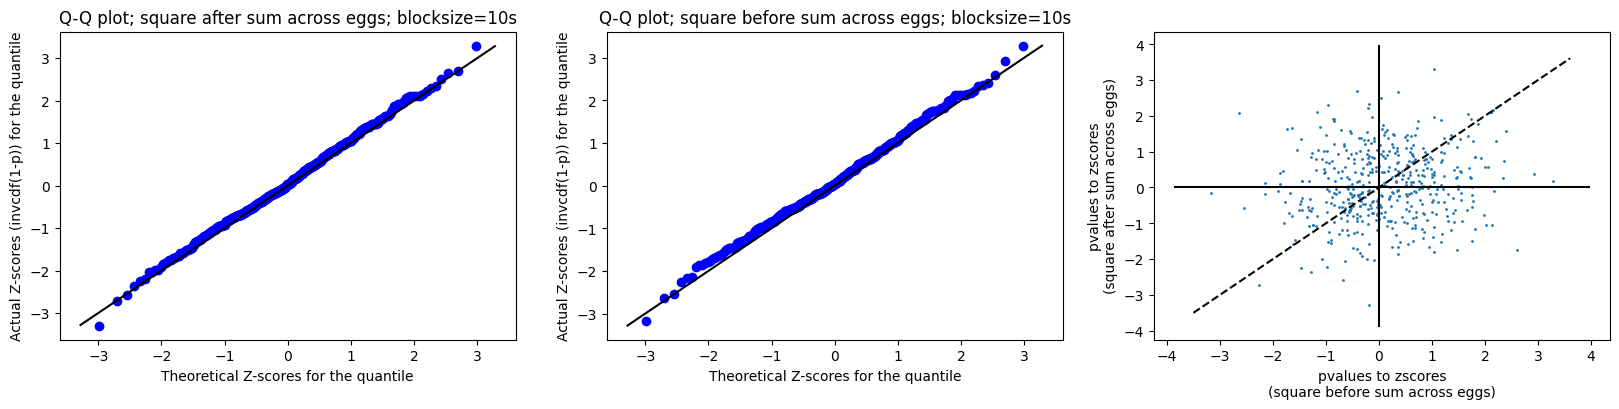

************TEST TYPE: controltimeshift_-3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.07235096038294911 pval: 0.4711613052017395
Meta-analysis Z-score if squaring *before* summing 2.0684850065514446 pval:  0.0192972195312896
Argmax event for square after summing: ('133', 'Lysistrata', datetime.datetime(2003, 3, 3, 7, 0), datetime.datetime(2003, 3, 4, 6, 59, 59), 86400.0) 3.501557559945988
Argmax event for square before summing: ('176', 'Turkish Train Wreck', datetime.datetime(2004, 7, 22, 4, 15), datetime.datetime(2004, 7, 22, 8, 14, 59), 14400.0) 3.0299067507397153
Correlation between the two scores: PearsonRResult(statistic=0.14830452598702895, pvalue=0.0010411452570448564)


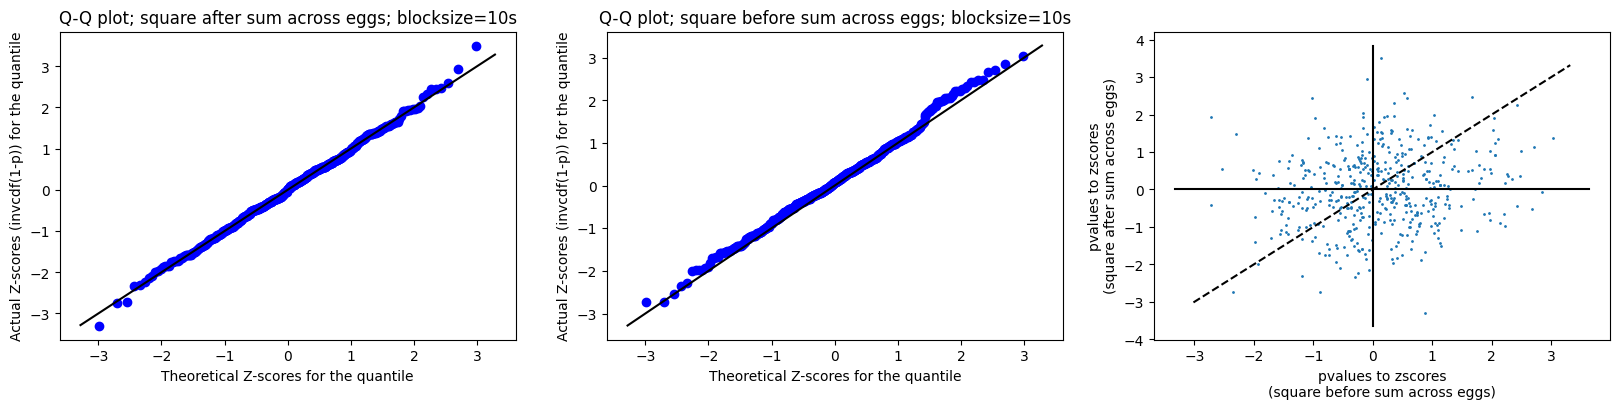

************TEST TYPE: controltimeshift_-2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.8570623663506194 pval: 0.8042947908606899
Meta-analysis Z-score if squaring *before* summing 3.1932087861765512 pval:  0.0007035058744101486
Argmax event for square after summing: ('295', 'Swine Flu Peak', datetime.datetime(2009, 4, 24, 16, 0), datetime.datetime(2009, 4, 25, 0, 59, 59), 32400.0) 2.4167019590529297
Argmax event for square before summing: ('325', 'Moscow Train Bombing', datetime.datetime(2010, 3, 29, 3, 30), datetime.datetime(2010, 3, 29, 7, 29, 59), 14400.0) 3.481590820950088
Correlation between the two scores: PearsonRResult(statistic=0.20570689035073136, pvalue=4.826242169390821e-06)


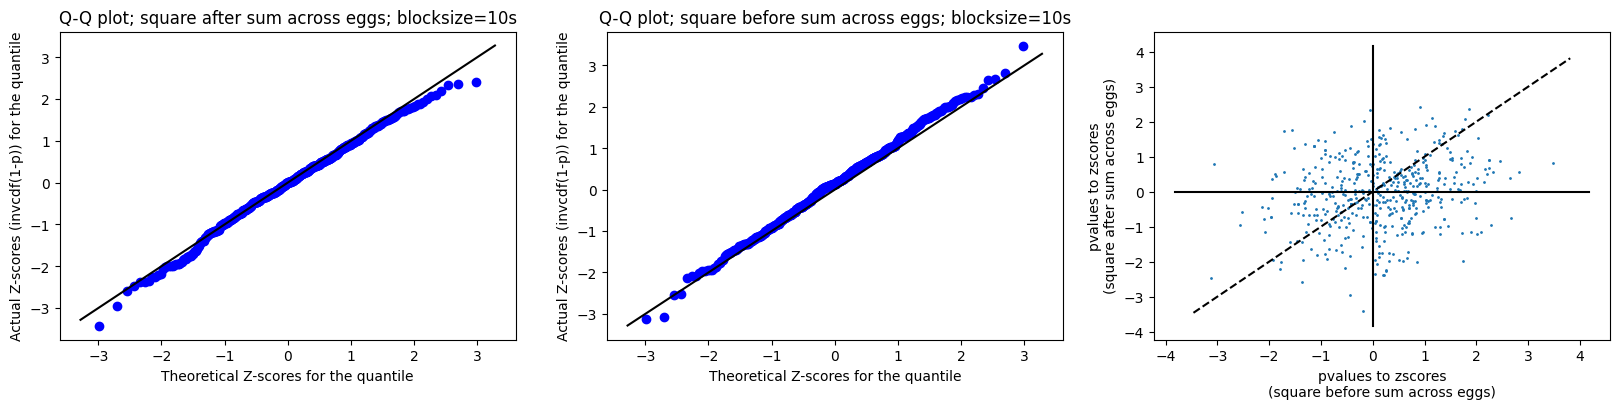

************TEST TYPE: controltimeshift_-1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.06376153600383665 pval: 0.5254199471350844
Meta-analysis Z-score if squaring *before* summing 0.8370022126136121 pval:  0.20129566216508388
Argmax event for square after summing: ('446', 'Hugo Chavez Dies', datetime.datetime(2013, 3, 5, 20, 25), datetime.datetime(2013, 3, 6, 4, 24, 59), 28800.0) 2.9023515632203254
Argmax event for square before summing: ('50', 'Kursk Tragedy, 30-min', datetime.datetime(2000, 8, 12, 7, 28), datetime.datetime(2000, 8, 12, 7, 57, 59), 1800.0) 2.8091409001898016
Correlation between the two scores: PearsonRResult(statistic=0.046066064366885054, pvalue=0.3108365945820635)


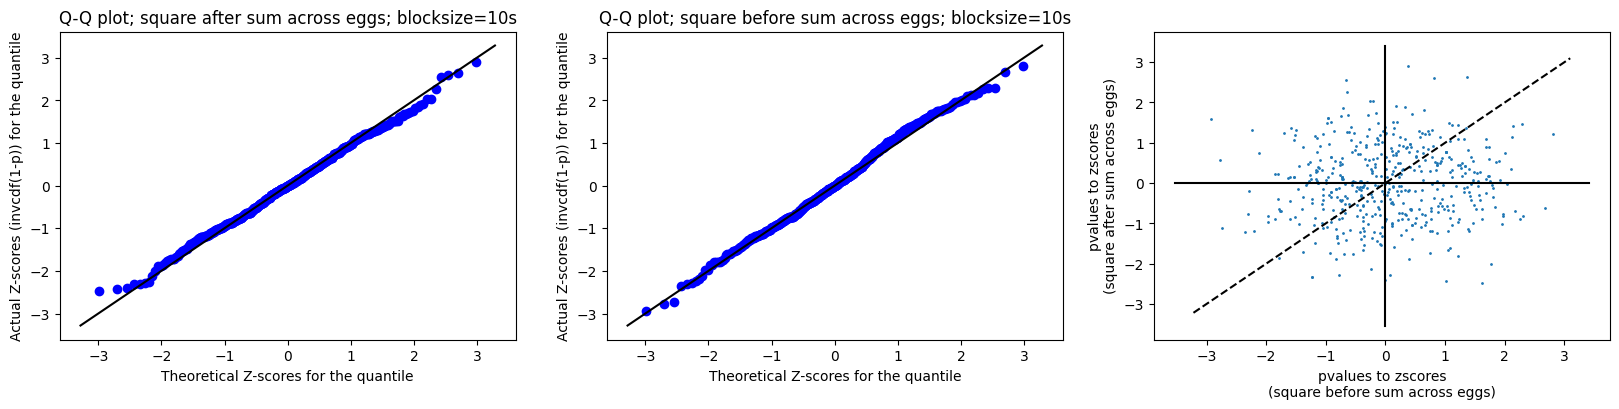

************TEST TYPE: controltimeshift_1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.03135989919227232 pval: 0.5125087393907171
Meta-analysis Z-score if squaring *before* summing 1.3593571986234838 pval:  0.08701671352276419
Argmax event for square after summing: ('479', 'Landslide Afghanistan', datetime.datetime(2014, 5, 2, 7, 0), datetime.datetime(2014, 5, 3, 6, 59, 59), 86400.0) 3.3825008675982087
Argmax event for square before summing: ('325', 'Moscow Train Bombing', datetime.datetime(2010, 3, 29, 3, 30), datetime.datetime(2010, 3, 29, 7, 29, 59), 14400.0) 2.877882945662356
Correlation between the two scores: PearsonRResult(statistic=0.21056905725867403, pvalue=2.8307777199011057e-06)


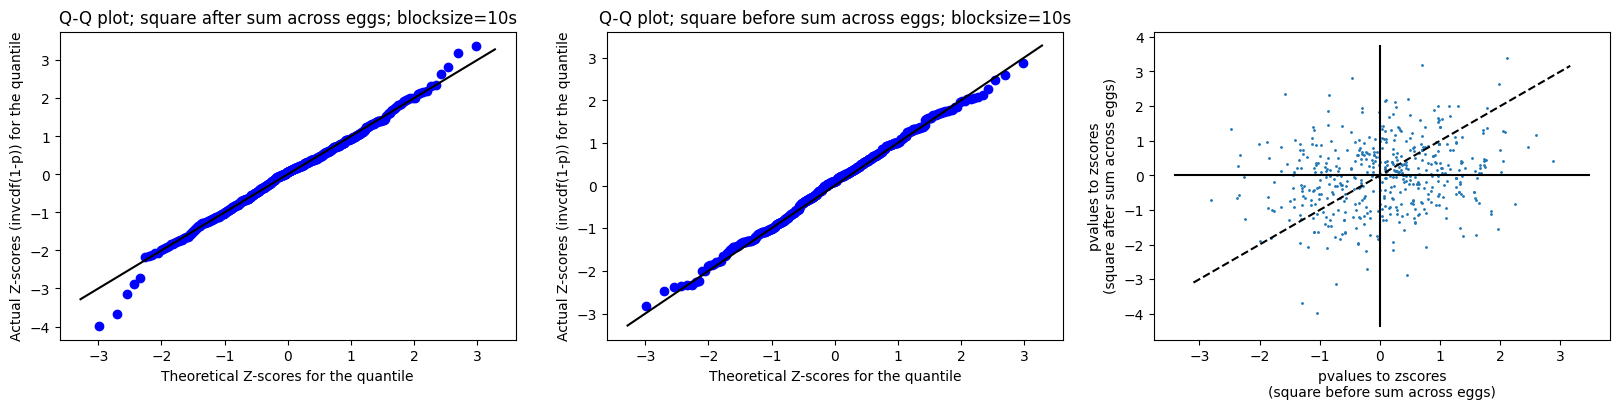

************TEST TYPE: controltimeshift_2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.810009294490465 pval: 0.03514717291490299
Meta-analysis Z-score if squaring *before* summing 2.944040032754691 pval:  0.001619790463445181
Argmax event for square after summing: ('132', 'Korean Subway', datetime.datetime(2003, 2, 18, 0, 45), datetime.datetime(2003, 2, 18, 12, 44, 59), 43200.0) 3.569256072550436
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 9.810885575739075
Correlation between the two scores: PearsonRResult(statistic=0.15616770706636388, pvalue=0.0005500129605705579)


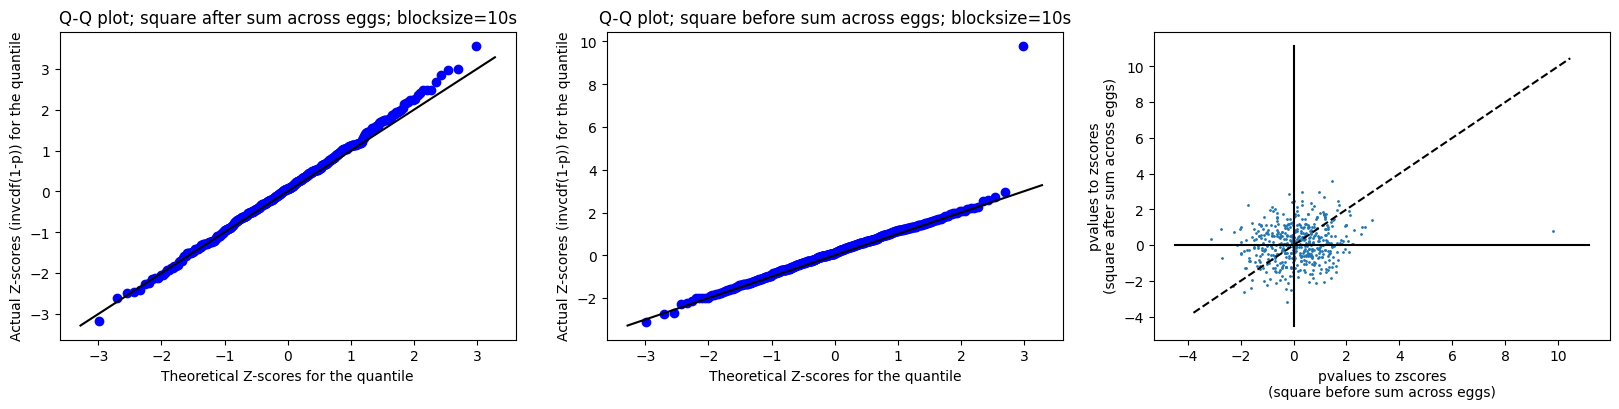

************TEST TYPE: controltimeshift_3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.4122166358607586 pval: 0.07894309180555026
Meta-analysis Z-score if squaring *before* summing 3.4588004169782613 pval:  0.00027129340144549374
Argmax event for square after summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 3.971997695653522
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 22.659258525333453
Correlation between the two scores: PearsonRResult(statistic=0.29956008587220195, pvalue=1.5582879578546994e-11)


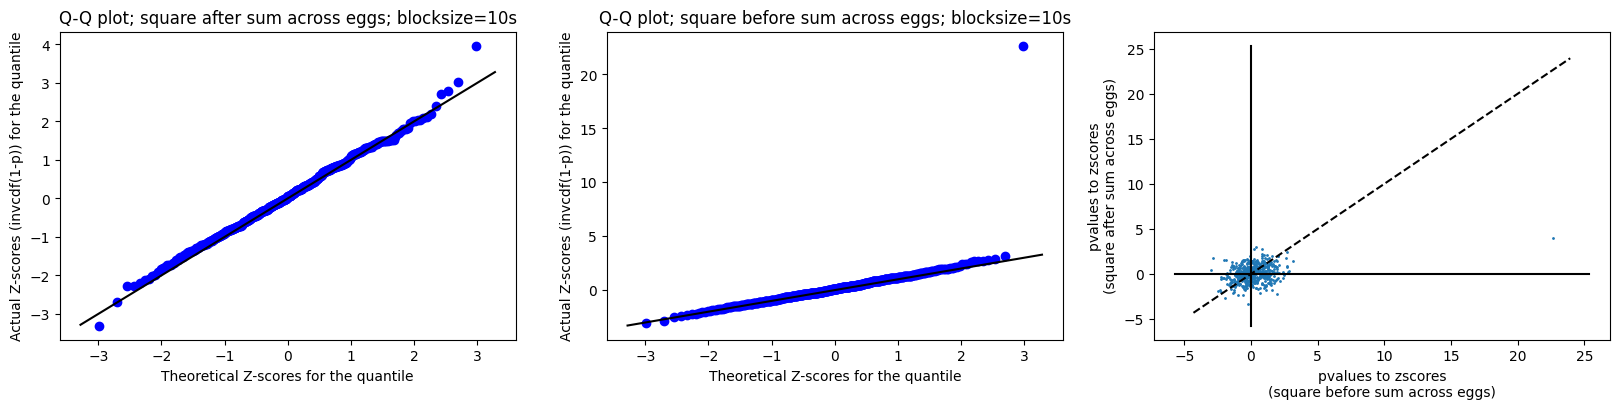




Blocksize: 15 seconds
************TEST TYPE: actual
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.49926626382553113 pval: 0.30879590915986466
Meta-analysis Z-score if squaring *before* summing 2.002302178993738 pval:  0.022626120903599722
Argmax event for square after summing: ('89', 'World Series, Yankee Stadium', datetime.datetime(2001, 11, 1, 0, 0), datetime.datetime(2001, 11, 1, 4, 59, 59), 18000.0) 2.841416405131285
Argmax event for square before summing: ('137', 'Begin War on Iraq -4 +4 hours', datetime.datetime(2003, 3, 19, 23, 15), datetime.datetime(2003, 3, 20, 7, 14, 59), 28800.0) 3.0185948021375433
Correlation between the two scores: PearsonRResult(statistic=0.17747004232804967, pvalue=8.368568880192691e-05)


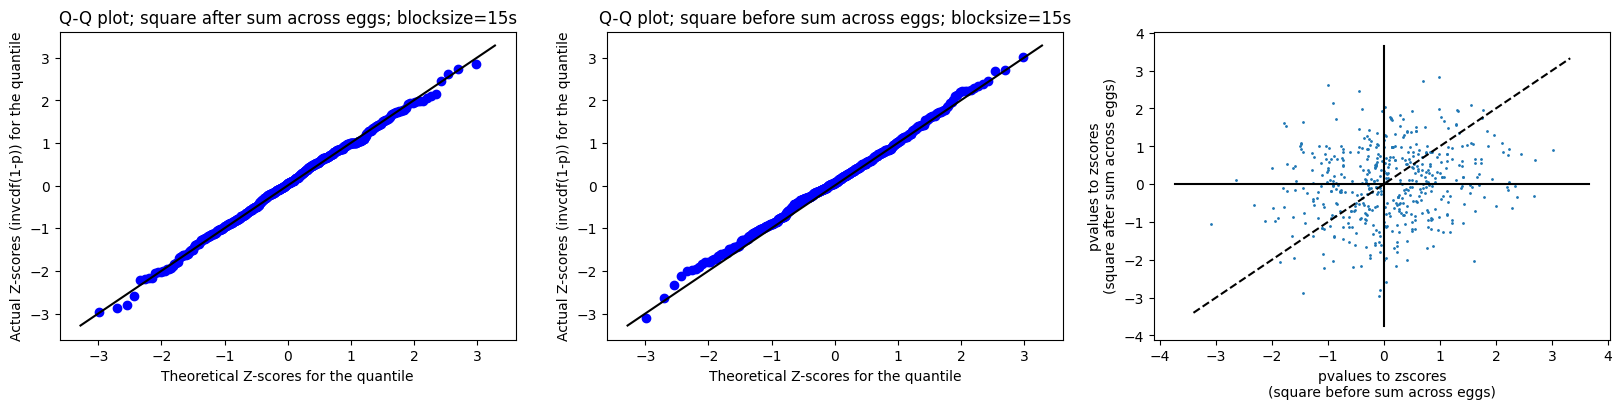

************TEST TYPE: controltimeshift_-3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.5901079225462524 pval: 0.7224408511567408
Meta-analysis Z-score if squaring *before* summing 2.0180293155940148 pval:  0.02179410414471361
Argmax event for square after summing: ('133', 'Lysistrata', datetime.datetime(2003, 3, 3, 7, 0), datetime.datetime(2003, 3, 4, 6, 59, 59), 86400.0) 3.0039100089159922
Argmax event for square before summing: ('275', 'Islamabad Hotel Bombing', datetime.datetime(2008, 9, 20, 13, 0), datetime.datetime(2008, 9, 20, 17, 59, 59), 18000.0) 2.709092789633745
Correlation between the two scores: PearsonRResult(statistic=0.12841173537569228, pvalue=0.004577600922063078)


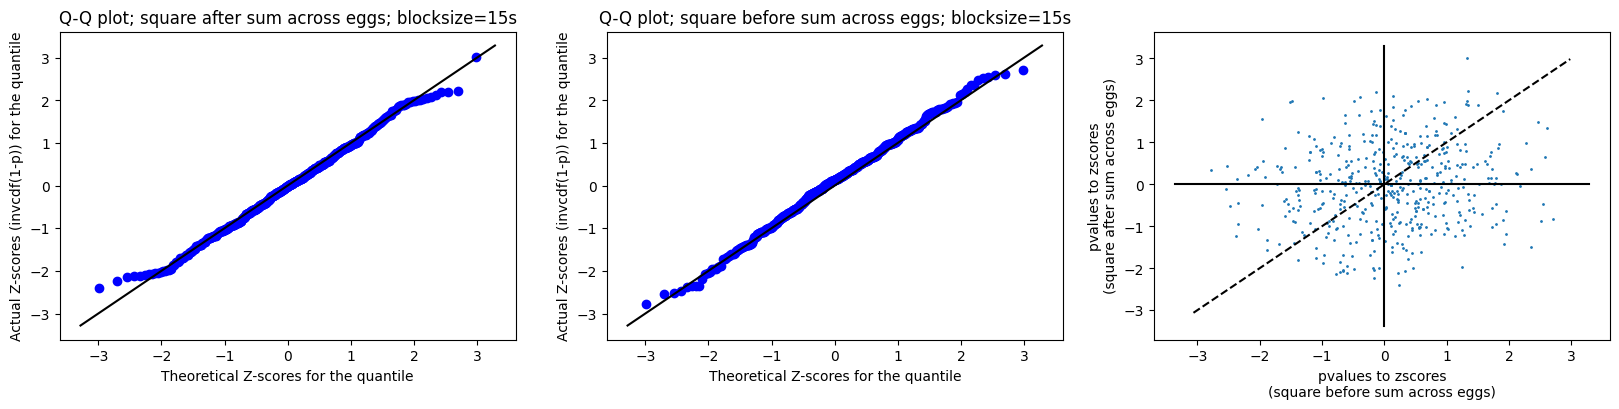

************TEST TYPE: controltimeshift_-2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.09414764539127299 pval: 0.5375040635582515
Meta-analysis Z-score if squaring *before* summing 2.8936955753045615 pval:  0.0019036854935797765
Argmax event for square after summing: ('49', 'Concorde Crash, Paris', datetime.datetime(2000, 7, 25, 15, 47), datetime.datetime(2000, 7, 25, 16, 16, 59), 1800.0) 3.056774355206611
Argmax event for square before summing: ('325', 'Moscow Train Bombing', datetime.datetime(2010, 3, 29, 3, 30), datetime.datetime(2010, 3, 29, 7, 29, 59), 14400.0) 2.6430387625430676
Correlation between the two scores: PearsonRResult(statistic=0.19994225217977624, pvalue=8.93825730660784e-06)


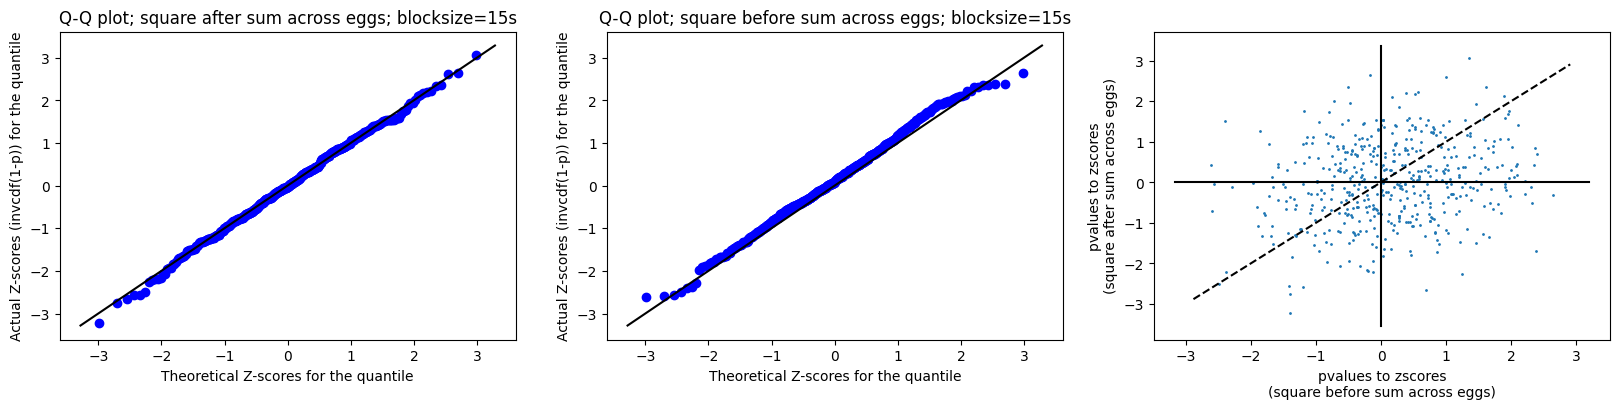

************TEST TYPE: controltimeshift_-1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: -0.6991917220980799 pval: 0.7577838884369621
Meta-analysis Z-score if squaring *before* summing 0.9677289772384983 pval:  0.1665898711261078
Argmax event for square after summing: ('171', 'Cricket, India vs Pakistan', datetime.datetime(2004, 3, 24, 9, 0), datetime.datetime(2004, 3, 24, 16, 59, 59), 28800.0) 3.488662747582012
Argmax event for square before summing: ('137', 'Begin War on Iraq -4 +4 hours', datetime.datetime(2003, 3, 19, 23, 15), datetime.datetime(2003, 3, 20, 7, 14, 59), 28800.0) 2.819909141391782
Correlation between the two scores: PearsonRResult(statistic=0.14002563919471472, pvalue=0.0019732388538414186)


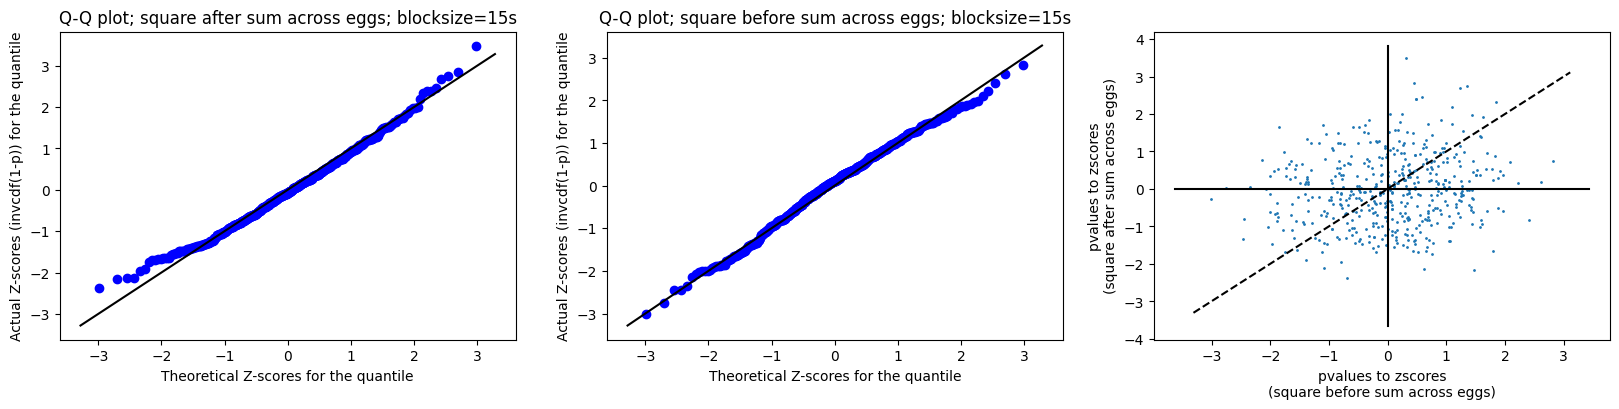

************TEST TYPE: controltimeshift_1
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.5105308837413941 pval: 0.3048397918158733
Meta-analysis Z-score if squaring *before* summing 2.2336935508971987 pval:  0.012751621815741854
Argmax event for square after summing: ('172', 'Rantisi Assassination', datetime.datetime(2004, 4, 17, 17, 0), datetime.datetime(2004, 4, 17, 20, 59, 59), 14400.0) 3.2756056678266536
Argmax event for square before summing: ('168', 'Terror Attacks in Madrid', datetime.datetime(2004, 3, 11, 6, 0), datetime.datetime(2004, 3, 11, 10, 59, 59), 18000.0) 2.8704687406591782
Correlation between the two scores: PearsonRResult(statistic=0.20293820623907347, pvalue=6.502914877172097e-06)


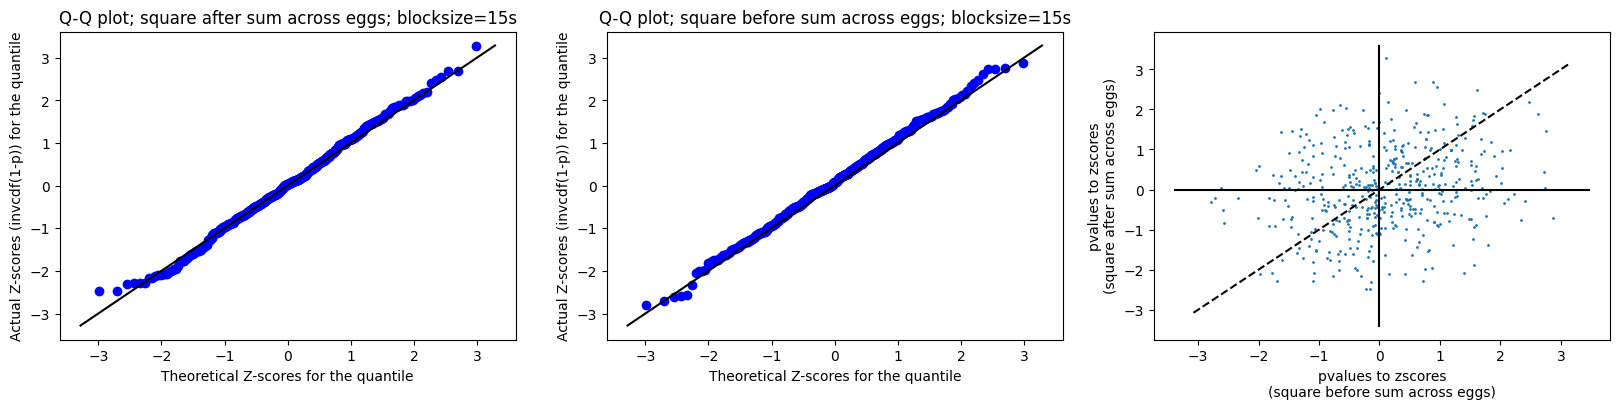

************TEST TYPE: controltimeshift_2
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 0.552924329181783 pval: 0.29015761356802294
Meta-analysis Z-score if squaring *before* summing 2.320957317296921 pval:  0.010144573792395972
Argmax event for square after summing: ('132', 'Korean Subway', datetime.datetime(2003, 2, 18, 0, 45), datetime.datetime(2003, 2, 18, 12, 44, 59), 43200.0) 3.2480777365491424
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 10.776724038504703
Correlation between the two scores: PearsonRResult(statistic=0.050413723469911874, pvalue=0.2673289821139919)


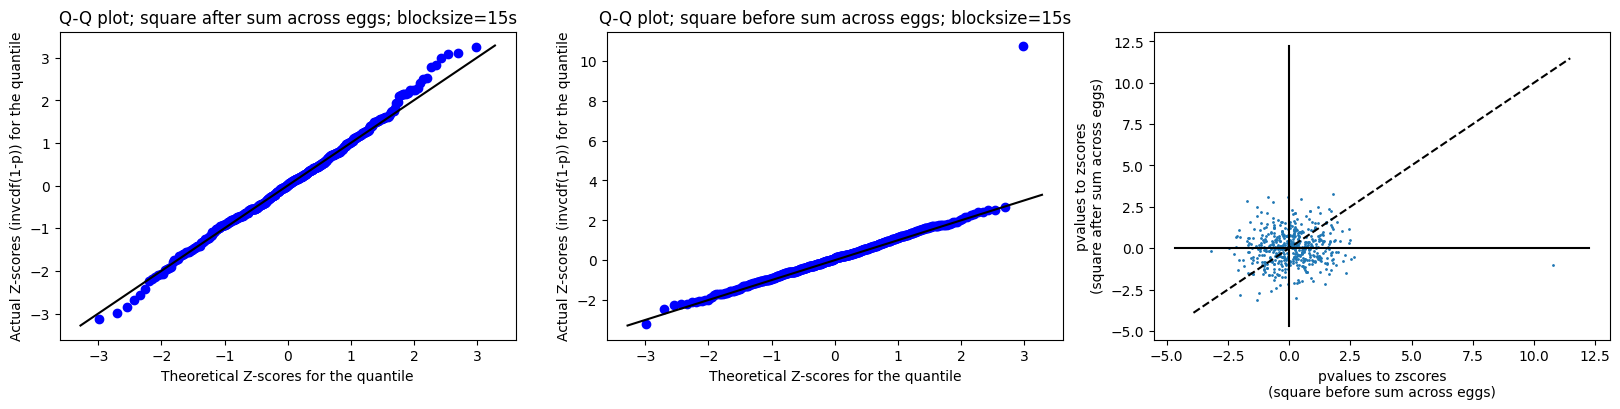

************TEST TYPE: controltimeshift_3
Nan warning for event: ('82', 'Silent Prayer, Sept 14', datetime.datetime(2001, 9, 14, 10, 0), datetime.datetime(2001, 9, 14, 10, 0), 1.0)
Meta-analysis Z-score if squaring *after* summing: 1.0709840705434257 pval: 0.1420882960995028
Meta-analysis Z-score if squaring *before* summing 3.1172925672414618 pval:  0.0009126017053705526
Argmax event for square after summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 3.216489686106191
Argmax event for square before summing: ('261', 'Earth Day, 2008', datetime.datetime(2008, 4, 22, 0, 0), datetime.datetime(2008, 4, 22, 23, 59, 59), 86400.0) 27.844495835124057
Correlation between the two scores: PearsonRResult(statistic=0.16892849832669704, pvalue=0.00018297598069582488)


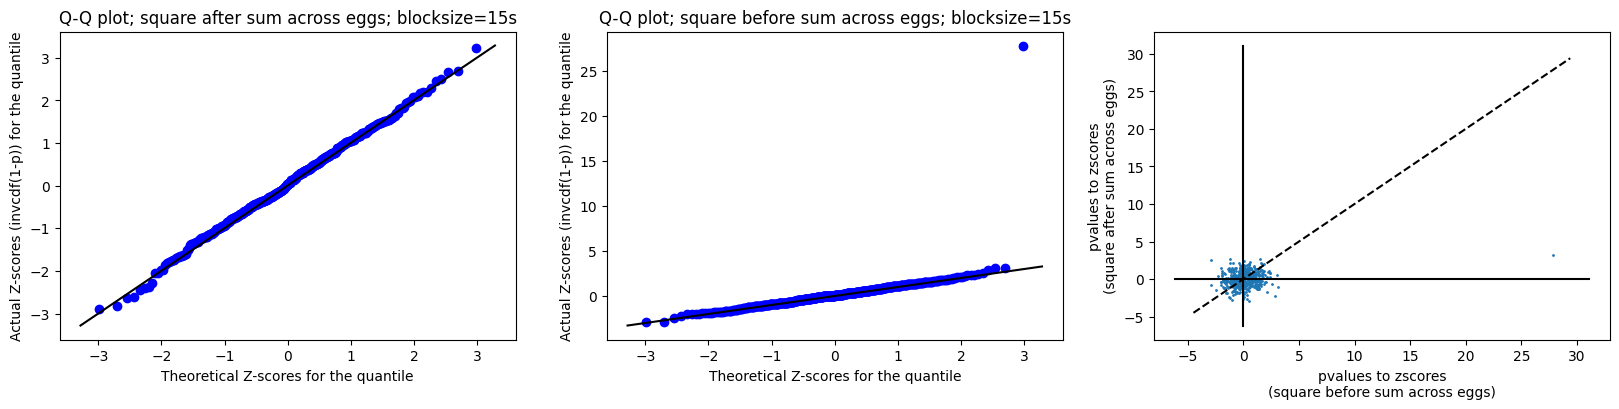

In [20]:
from matplotlib import pyplot as plt

print("num events after dropping events with missing data:", len(included_events))

for blocksize_counter, blocksize in enumerate(BLOCKSIZES):
  print("\n\n\nBlocksize:", blocksize, "seconds")

  for (touse_pvaltozs_sumthensquare, touse_pvaltozs_squarethensum, testtype) in (
      [ (all_pvaltozs_sumthensquare, all_pvaltozs_squarethensum, "actual")]
      +[ (controls_all_pvaltozs_sumthensquare[control_timeshift],
          controls_all_pvaltozs_squarethensum[control_timeshift],
          "controltimeshift_"+str(control_timeshift))
         for control_timeshift in control_timeshifts ]):

    print("************TEST TYPE:", testtype)

    for i in range(len(touse_pvaltozs_sumthensquare)):
      if np.isnan(touse_pvaltozs_sumthensquare[i][blocksize_counter]):
        print("Nan warning for event:", surviving_events[i])

    pvaltoz_sumthensquare = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_sumthensquare]) if np.isnan(x)==False]
    pvaltoz_squarethensum = [x for x in np.array([x[blocksize_counter] for x in touse_pvaltozs_squarethensum]) if np.isnan(x)==False]

    metaz_sumthensquare = np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare))
    metaz_squarethensum = np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum))
    print("Meta-analysis Z-score if squaring *after* summing:", metaz_sumthensquare, "pval:", 1-scipy.stats.norm.cdf(metaz_sumthensquare))
    print("Meta-analysis Z-score if squaring *before* summing", metaz_squarethensum, "pval: ", 1-scipy.stats.norm.cdf(metaz_squarethensum))
    print("Argmax event for square after summing:", surviving_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
    print("Argmax event for square before summing:", surviving_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
    print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

    fig, ax = plt.subplots(ncols=3, figsize=(20,4))
    plt.sca(ax[0])
    scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square after sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[1])
    scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
    plt.plot(plt.xlim(), plt.xlim(), color="black")
    plt.title("Q-Q plot; square before sum across eggs; blocksize="+str(blocksize)+"s")
    plt.xlabel("Theoretical Z-scores for the quantile")
    plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
    plt.sca(ax[2])
    plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
    plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
    plt.plot(plt.xlim(), [0,0], color="black")
    plt.plot([0,0], plt.ylim(), color="black")
    plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
    plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
    plt.show()